## Data AIS

In [1]:
#For 3.3.1
#Register Sedona Functions to Spark
from sedona.register import SedonaRegistrator
SedonaRegistrator.registerAll(spark)

True

In [2]:
#For 3.3.2
from shapely.geometry import Point, Polygon, mapping
import h3.api.numpy_int as h3int

In [3]:
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when

In [4]:
# Path
base_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
path_unique = base_path + "212112409/"

In [5]:
# Read Data
data_ais = spark.read.parquet(path_unique + "ais-data-indonesia-2020.parquet")

## Eksplorasi

In [6]:
data_ais.count()

170083

In [7]:
data_ais.show()

+---------+-------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------------+----------+-------------+------+-----+------------------------------+----------------+--------------+--------------+-------+----+--------------------+--------+------------+----------------+--------------------+--------------------+------------------+--------+
|     mmsi|    imo|         longitude|            latitude|         dt_pos_utc|    H3_int_index_8|vessel_type|      ShiptypeLevel5|GrossTonnage|Deadweight|SummerDraught|length|width|LengthBetweenPerpendicularsLBP|LengthOverallLOA|BreadthMoulded|BreadthExtreme|draught| sog|          nav_status|Speedmax|Speedservice|            prov|              kabkot|                Port|       boundary_h3|position|
+---------+-------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------------+----------+-------------+------+-----+----------

In [8]:
from pyspark.sql.functions import col, expr, mean

# Daftar variabel yang akan dianalisis
variables = ["GrossTonnage", "Deadweight", "SummerDraught", "LengthBetweenPerpendicularsLBP", 
              "length", "width", "LengthOverallLOA", "BreadthMoulded","BreadthExtreme", "draught", "Speedmax", "Speedservice"]

# Fungsi untuk menghitung 5-number summary + rata-rata
def five_number_summary_with_mean(df, column):
    df.select(
        expr(f"percentile_approx({column}, 0) AS min"),
        expr(f"percentile_approx({column}, 0.25) AS Q1"),
        expr(f"percentile_approx({column}, 0.5) AS median"),
        expr(f"percentile_approx({column}, 0.75) AS Q3"),
        expr(f"percentile_approx({column}, 1) AS max"),
        mean(column).alias("mean")
    ).show(truncate=False)

In [9]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
for var in variables:
    print(f"5-Number Summary + Mean for {var}:")
    five_number_summary_with_mean(data_ais, var)

5-Number Summary + Mean for GrossTonnage:
+---+----+------+-----+------+------------------+
|min|Q1  |median|Q3   |max   |mean              |
+---+----+------+-----+------+------------------+
|211|2810|5261  |14320|203997|11133.142318750257|
+---+----+------+-----+------+------------------+

5-Number Summary + Mean for Deadweight:
+---+----+------+-----+------+------------------+
|min|Q1  |median|Q3   |max   |mean              |
+---+----+------+-----+------+------------------+
|0  |3639|7052  |18010|403784|16369.953346307391|
+---+----+------+-----+------+------------------+

5-Number Summary + Mean for SummerDraught:
+---+---+------+---+-----+-----------------+
|min|Q1 |median|Q3 |max  |mean             |
+---+---+------+---+-----+-----------------+
|0.0|5.1|6.875 |9.0|23.04|7.295402809215721|
+---+---+------+---+-----+-----------------+

5-Number Summary + Mean for LengthBetweenPerpendicularsLBP:
+---+-----+------+-----+-------+----------------+
|min|Q1   |median|Q3   |max    |mean 

In [10]:
from pyspark.sql.functions import col, count, when

# Periksa jumlah nilai null untuk setiap kolom
for column in variables:
    null_count = data_ais.filter(col(column).isNull()).count()
    print(f"Kolom '{column}' memiliki {null_count} nilai null.")

Kolom 'GrossTonnage' memiliki 0 nilai null.
Kolom 'Deadweight' memiliki 0 nilai null.
Kolom 'SummerDraught' memiliki 0 nilai null.
Kolom 'LengthBetweenPerpendicularsLBP' memiliki 0 nilai null.
Kolom 'length' memiliki 3 nilai null.
Kolom 'width' memiliki 1 nilai null.
Kolom 'LengthOverallLOA' memiliki 0 nilai null.
Kolom 'BreadthMoulded' memiliki 0 nilai null.
Kolom 'BreadthExtreme' memiliki 0 nilai null.
Kolom 'draught' memiliki 0 nilai null.
Kolom 'Speedmax' memiliki 0 nilai null.
Kolom 'Speedservice' memiliki 0 nilai null.


In [11]:
from pyspark.sql.functions import col, countDistinct

# Cek apakah dalam setiap MMSI hanya ada satu nilai unik draught
mmsi_constant_draught = (
    data_ais.groupBy("mmsi")
    .agg(countDistinct("draught").alias("unique_draught_count"))
    .filter(col("unique_draught_count") == 1)  # Hanya ambil yang memiliki 1 nilai unik
    .select("mmsi")
)

# Hitung jumlah MMSI unik
count_mmsi_unique = mmsi_constant_draught.count()

# Ambil semua baris yang sesuai dengan MMSI tersebut
filtered_data = data_ais.join(mmsi_constant_draught, "mmsi", "inner")

# Hitung jumlah data pada data_ais yang memenuhi syarat
count_data_ais = filtered_data.count()

# Cetak hasil
print(f"Jumlah data_ais dengan draught konstan dalam satu MMSI: {count_data_ais}")
print(f"Jumlah MMSI unik dengan draught konstan: {count_mmsi_unique}")

Jumlah data_ais dengan draught konstan dalam satu MMSI: 5718
Jumlah MMSI unik dengan draught konstan: 104


In [13]:
# Hitung jumlah total MMSI unik yang memiliki lebih dari satu IMO
total_mmsi_multiple_imo = data_ais.groupBy("mmsi").agg(countDistinct("imo").alias("unique_imo_count"))
total_mmsi_multiple_imo_count = total_mmsi_multiple_imo.filter(col("unique_imo_count") > 1).count()

print(f"Total MMSI dengan lebih dari satu IMO: {total_mmsi_multiple_imo_count}")

Total MMSI dengan lebih dari satu IMO: 54


In [7]:
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import col

columns_to_update = ["GrossTonnage", "Deadweight", "SummerDraught", "LengthBetweenPerpendicularsLBP", "LengthOverallLOA", "BreadthMoulded", "BreadthExtreme", "Speedmax", "Speedservice"]

for column in columns_to_update:
    mode_df = data_ais.groupBy("mmsi", column).count().withColumnRenamed("count", "cnt")
    
    # Gunakan Window yang diimpor dengan benar
    window_spec = Window.partitionBy("mmsi").orderBy(F.desc("cnt"))
    mode_df = mode_df.withColumn("rank", F.dense_rank().over(window_spec))
    mode_df = mode_df.filter(col("rank") == 1).drop("cnt", "rank")
    
    data_ais = data_ais.drop(column).join(mode_df, on=["mmsi"], how="left")

In [8]:
data_ais.filter(col("mmsi") == 111150465).show(truncate=False)

+---------+-------+------------------+-------------------+-------------------+------------------+-----------+---------------+------+-----+-------+---+----------------------+------+------------------+----------+------------------+--------+------------+----------+-------------+------------------------------+----------------+--------------+--------------+--------+------------+
|mmsi     |imo    |longitude         |latitude           |dt_pos_utc         |H3_int_index_8    |vessel_type|ShiptypeLevel5 |length|width|draught|sog|nav_status            |prov  |kabkot            |Port      |boundary_h3       |position|GrossTonnage|Deadweight|SummerDraught|LengthBetweenPerpendicularsLBP|LengthOverallLOA|BreadthMoulded|BreadthExtreme|Speedmax|Speedservice|
+---------+-------+------------------+-------------------+-------------------+------------------+-----------+---------------+------+-----+-------+---+----------------------+------+------------------+----------+------------------+--------+--------

## Imputasi Draught

In [13]:
#from pyspark.sql.functions import col, countDistinct

# Filter draught == 0
filtered_data = data_ais_filtered.filter(col("draught") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan Deadweight = 0: {record_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi", "draught").show(truncate=False)

Jumlah record dengan Deadweight = 0: 446
+---------+-------+
|mmsi     |draught|
+---------+-------+
|538005773|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
|525019324|0.0    |
+---------+-------+
only showing top 20 rows



In [14]:
from pyspark.sql.functions import col, avg, when, count

# Step 1: Identifikasi MMSI dengan semua draught = 0
mmsi_all_zero = (
    data_ais_filtered.groupBy("mmsi")
    .agg(count(when(col("draught") != 0, 1)).alias("non_zero_count"))
#    .filter(col("non_zero_count") == 0)
#    .select("mmsi")
#)

# Hapus seluruh record dengan MMSI yang hanya memiliki draught = 0
#cleaned_data_ais = data_ais_filtered.join(mmsi_all_zero, "mmsi", "left_anti")

# Step 2: Imputasi draught = 0 dengan rata-rata draught yang tidak nol pada MMSI yang sama
#mmsi_draught_avg = (
#    cleaned_data_ais.filter(col("draught") != 0)
#    .groupBy("mmsi")
#    .agg(avg("draught").alias("avg_draught"))
#)

# Gabungkan rata-rata ke data asli dan imputasi draught yang 0
#imputed_draught = (
#    cleaned_data_ais.join(mmsi_draught_avg, "mmsi", "left")
#    .withColumn(
#        "draught",
#        when(col("draught") == 0, col("avg_draught")).otherwise(col("draught"))
#    )
#    .drop("avg_draught")
#)

# Tampilkan hasil untuk verifikasi
#imputed_draught.select("mmsi", "draught").show(truncate=False)

+---------+-----------------+
|mmsi     |draught          |
+---------+-----------------+
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.899999999999999|
|111150465|3.899999999999999|
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|111150465|3.9              |
|219127000|8.3              |
|219127000|8.3              |
|219127000|8.3              |
|219127000|8.3              |
|219127000|8.3              |
|219127000|8.3              |
|219127000|8.3              |
+---------+-----------------+
only showing top 20 rows



In [15]:
from pyspark.sql.functions import col

# Simpan data sebelum imputasi (data dengan draught = 0)
before_imputation = filtered_data.select("mmsi", "draught")

# Gabungkan data sebelum imputasi dengan data setelah imputasi
comparison = before_imputation.join(imputed_draught.select("mmsi", "draught"), "mmsi", "inner")

# Tampilkan hasil perbandingan
comparison.withColumnRenamed("draught", "draught_before") \
          .withColumnRenamed("draught", "draught_after") \
          .show(truncate=False)

+---------+--------------+-----------------+
|mmsi     |draught_before|draught_before   |
+---------+--------------+-----------------+
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.899999999999999|
|111150465|0.0           |3.899999999999999|
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.9              |
|111150465|0.0           |3.899999999999999|
|111150465

In [16]:
from pyspark.sql.functions import col, countDistinct

# Filter draught == 0
filtered_data = imputed_draught.filter(col("draught") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan Deadweight = 0: {record_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi", "draught").show(truncate=False)

Jumlah record dengan Deadweight = 0: 0
+----+-------+
|mmsi|draught|
+----+-------+
+----+-------+



In [30]:
imputed_draught.count()

10164

In [31]:
# Menghitung jumlah kapal unik berdasarkan kolom 'mmsi'
unique_ship_count = imputed_draught.select("mmsi").distinct().count()

print(f"Jumlah kapal unik: {unique_ship_count}")

Jumlah kapal unik: 425


## Imputasi DWT

In [9]:
from pyspark.sql.functions import col, countDistinct

# Filter Deadweight == 0
filtered_data = data_ais.filter(col("Deadweight") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan Deadweight = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi", "Deadweight","LengthOverallLOA","BreadthMoulded","GrossTonnage","SummerDraught").distinct().show(n=100, truncate=False)

Jumlah record dengan Deadweight = 0: 690
Jumlah MMSI unik: 3
+---------+----------+----------------+--------------+------------+-------------+
|mmsi     |Deadweight|LengthOverallLOA|BreadthMoulded|GrossTonnage|SummerDraught|
+---------+----------+----------------+--------------+------------+-------------+
|525006134|0         |54.06           |14.0          |738         |2.84         |
|525018391|0         |38.3            |7.5           |214         |1.75         |
|525022370|0         |89.52           |13.5          |2003        |5.33         |
+---------+----------+----------------+--------------+------------+-------------+



In [10]:
from pyspark.sql.functions import min, max, col, when

# Menentukan kelas kapal berdasarkan Deadweight
data_ais = data_ais.withColumn("kelas_kapal", when((col("Deadweight") > 0) & (col("Deadweight") < 40000), "Handysize")
                               .when((col("Deadweight") >= 40000) & (col("Deadweight") < 60000), "Handymax")
                               .when((col("Deadweight") >= 60000) & (col("Deadweight") < 80000), "Panamax")
                               .when((col("Deadweight") >= 80000) & (col("Deadweight") < 120000), "Aframax")
                               .when((col("Deadweight") >= 120000) & (col("Deadweight") < 200000), "Suezmax")
                               .when((col("Deadweight") >= 200000) & (col("Deadweight") < 320000), "VLCC")
                               .when(col("Deadweight") >= 320000, "ULCC")
                               .otherwise("Unknown"))

# Menghitung nilai minimum dan maksimum GT untuk setiap kelas kapal
result = data_ais.groupBy("kelas_kapal").agg(
    min("GrossTonnage").alias("min_GT"),
    max("GrossTonnage").alias("max_GT")
).orderBy("min_GT")

# Menampilkan hasil
result.show()

+-----------+------+------+
|kelas_kapal|min_GT|max_GT|
+-----------+------+------+
|  Handysize|   211| 46555|
|    Unknown|   214|  2003|
|   Handymax| 21897| 50676|
|    Panamax| 40803|136894|
|    Aframax| 44387|136739|
|    Suezmax| 78845| 84214|
|       VLCC|113925|164680|
|       ULCC|160290|203997|
+-----------+------+------+



In [11]:
from pyspark.sql.functions import col, avg, min, max, when, broadcast, lit
from pyspark.sql.window import Window
from pyspark.sql.functions import lead

# 1. Hitung rentang GrossTonnage dan avg_dwt untuk setiap kelas kapal (kecuali Unknown)
result = data_ais.filter((col("kelas_kapal") != "Unknown") & (col("Deadweight") > 0)) \
    .groupBy("kelas_kapal") \
    .agg(
        min("GrossTonnage").alias("min_GT"),
        max("GrossTonnage").alias("max_GT"),
        avg("Deadweight").alias("avg_dwt")  
    )

# Tentukan kelas_kapal dengan min_GT paling rendah
min_gt_global = result.select(min("min_GT")).collect()[0][0]

# Setel batas bawah min_GT paling rendah menjadi 0
result = result.withColumn(
    "min_GT", when(col("min_GT") == min_gt_global, lit(0)).otherwise(col("min_GT"))
)

# Menentukan batas atas rentang GT sebagai 1 angka sebelum min_GT di kelas selanjutnya
window_spec = Window.orderBy("min_GT")
result = result.withColumn("max_range_GT", lead("min_GT", 1).over(window_spec) - 1)
result = result.withColumn("max_range_GT", when(col("max_range_GT").isNull(), col("max_GT")).otherwise(col("max_range_GT")))

# 2. Gabungkan `result` ke `data_ais`, tetapi HANYA dengan kolom yang dibutuhkan
result = result.drop("kelas_kapal")  # Hapus kelas_kapal sebelum join agar tidak duplikat

imputed_dwt = data_ais.join(
    broadcast(result), 
    (col("GrossTonnage") >= col("min_GT")) & (col("GrossTonnage") <= col("max_range_GT")), 
    "left"
)

# 3. Imputasi Deadweight = 0 dengan rata-rata dari rentang yang sesuai
imputed_dwt = imputed_dwt.withColumn(
    "Deadweight",
    when((col("Deadweight") == 0) & col("avg_dwt").isNotNull(), col("avg_dwt"))
    .otherwise(col("Deadweight"))
)

# Hapus kolom tambahan yang tidak diperlukan setelah imputasi
imputed_dwt = imputed_dwt.drop("min_GT", "max_GT", "max_range_GT", "avg_dwt")

# Tampilkan hasil untuk verifikasi
imputed_dwt.filter(col("Deadweight") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+------------------------------+----------------+--------------+--------------+--------+------------+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LengthBetweenPerpendicularsLBP|LengthOverallLOA|BreadthMoulded|BreadthExtreme|Speedmax|Speedservice|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+------------------------------+----------------+--------------+--------------+--------+------------+-----------+
+----+---+---------+--------+----------+--------------+-----------+------------

In [20]:
from pyspark.sql.functions import col

# Simpan data sebelum imputasi (data dengan draught = 0)
before_imputation = filtered_data.select("mmsi", "Deadweight")

# Gabungkan data sebelum imputasi dengan data setelah imputasi
comparison = before_imputation.join(imputed_dwt.select("mmsi", "Deadweight","GrossTonnage"), "mmsi", "inner")

# Tampilkan hasil perbandingan
comparison.withColumnRenamed("Deadweight", "Deadweight_before") \
          .withColumnRenamed("Deadweight", "Deadweight_after") \
          .show(n=10000, truncate=False)

+---------+-----------------+------------------+------------+
|mmsi     |Deadweight_before|Deadweight_before |GrossTonnage|
+---------+-----------------+------------------+------------+
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|525006134|0                |10140.370483390427|738         |
|5250061

In [21]:
imputed_dwt.count()

170083

In [12]:
from pyspark.sql.functions import col, when, countDistinct

# 1️⃣ Menentukan kelas kapal berdasarkan Deadweight
imputed_dwt = imputed_dwt.withColumn(
    "kelas_kapal",
    when((col("Deadweight") > 0) & (col("Deadweight") < 40000), "Handysize")
    .when((col("Deadweight") >= 40000) & (col("Deadweight") < 60000), "Handymax")
    .when((col("Deadweight") >= 60000) & (col("Deadweight") < 80000), "Panamax")
    .when((col("Deadweight") >= 80000) & (col("Deadweight") < 120000), "Aframax")
    .when((col("Deadweight") >= 120000) & (col("Deadweight") < 200000), "Suezmax")
    .when((col("Deadweight") >= 200000) & (col("Deadweight") < 320000), "VLCC")
    .when(col("Deadweight") >= 320000, "ULCC")
    .otherwise("Unknown")
)

# 2️⃣ Menghitung jumlah unik MMSI untuk setiap kelas kapal
result = imputed_dwt.groupBy("kelas_kapal").agg(countDistinct("mmsi").alias("jumlah_kapal"))

# 3️⃣ Menampilkan hasil
result.show()

+-----------+------------+
|kelas_kapal|jumlah_kapal|
+-----------+------------+
|  Handysize|        1413|
|    Panamax|          58|
|    Suezmax|          18|
|   Handymax|         368|
|    Aframax|         101|
|       VLCC|          34|
|       ULCC|           8|
+-----------+------------+



## Imputasi Panjang & Lebar

In [13]:
# Ubah nama kolom di imputed_data
renamed_data = imputed_dwt \
    .withColumnRenamed("LengthBetweenPerpendicularsLBP", "LBP") \
    .withColumnRenamed("LengthOverallLOA", "LOA") \
    .withColumnRenamed("Speedservice", "speed")

In [14]:
renamed_data.show()

+---------+-------+------------------+-------------------+-------------------+------------------+-----------+--------------------+------+-----+-------+----+--------------------+--------------+-------------------+--------------------+------------------+--------+------------+----------+-------------+------+------+--------------+--------------+--------+-----+-----------+
|     mmsi|    imo|         longitude|           latitude|         dt_pos_utc|    H3_int_index_8|vessel_type|      ShiptypeLevel5|length|width|draught| sog|          nav_status|          prov|             kabkot|                Port|       boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|   LBP|   LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+---------+-------+------------------+-------------------+-------------------+------------------+-----------+--------------------+------+-----+-------+----+--------------------+--------------+-------------------+--------------------+------------------+------

In [15]:
from pyspark.sql.functions import col, countDistinct

# Filter LBP == 0
filtered_data = renamed_data.filter(col("LBP") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan LBP = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi","LBP","LOA","length").distinct().show(n=100, truncate=False)

Jumlah record dengan LBP = 0: 2905
Jumlah MMSI unik: 11
+---------+---+-----+------+
|mmsi     |LBP|LOA  |length|
+---------+---+-----+------+
|525119035|0.0|0.0  |90.0  |
|525200402|0.0|76.29|76.0  |
|525010322|0.0|58.2 |60.0  |
|677042300|0.0|73.03|0.0   |
|525119034|0.0|0.0  |90.0  |
|525200523|0.0|0.0  |0.0   |
|525100306|0.0|79.8 |0.0   |
|525100306|0.0|79.8 |90.0  |
|525100306|0.0|79.8 |80.0  |
|525100306|0.0|79.8 |79.0  |
|374746000|0.0|88.28|82.0  |
|525023236|0.0|74.68|75.0  |
|525100438|0.0|79.8 |74.0  |
|525021305|0.0|88.28|88.0  |
+---------+---+-----+------+



In [16]:
from pyspark.sql.functions import col, countDistinct

# Filter BreadthMoulded == 0
filtered_data = renamed_data.filter(col("BreadthMoulded") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan BreadthMoulded = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi","BreadthMoulded","BreadthExtreme","width").distinct().show(n=100, truncate=False)

Jumlah record dengan BreadthMoulded = 0: 249
Jumlah MMSI unik: 3
+---------+--------------+--------------+-----+
|mmsi     |BreadthMoulded|BreadthExtreme|width|
+---------+--------------+--------------+-----+
|525007030|0.0           |15.0          |14.0 |
|525200402|0.0           |0.0           |18.0 |
|525021181|0.0           |15.0          |16.0 |
|525021181|0.0           |15.0          |14.0 |
+---------+--------------+--------------+-----+



In [17]:
from pyspark.sql import functions as F

# Step 1: Isi LBP dengan LOA jika LBP == 0 dan LOA > 0, jika masih 0 cek length
imputed_data = renamed_data.withColumn(
    "LBP",
    F.when((F.col("LBP") == 0) & (F.col("LOA") > 0), F.col("LOA"))
    .when((F.col("LBP") == 0) & (F.col("length") > 0), F.col("length"))
    .otherwise(F.col("LBP"))
)

# Step 2: Hitung rata-rata LBP berdasarkan kelas_kapal (hanya untuk LBP > 0)
avg_LBP = (
    imputed_data.filter(F.col("LBP") > 0)
    .groupBy("kelas_kapal")
    .agg(F.avg("LBP").alias("avg_LBP"))
)

# Step 3: Gabungkan hasil rata-rata ke dataset utama dengan alias yang eksplisit
imputed_data = imputed_data.alias("a").join(
    avg_LBP.alias("b"),
    F.col("a.kelas_kapal") == F.col("b.kelas_kapal"),
    how="left"
).select(
    F.col("a.*"),  # Pilih semua kolom dari imputed_data
    F.col("b.avg_LBP")  # Ambil hanya avg_LBP dari avg_LBP dataset
)

# Step 4: Isi LBP dengan rata-rata jika LBP, LOA, dan length semuanya nol
imputed_data = imputed_data.withColumn(
    "LBP",
    F.when(
        (F.col("LBP") == 0) & (F.col("LOA") == 0) & (F.col("length") == 0),
        F.col("avg_LBP")
    ).otherwise(F.col("LBP"))
)

# Step 5: Hapus kolom avg_LBP setelah digunakan agar dataset tetap bersih
imputed_data = imputed_data.drop("avg_LBP")

# Step 6: Cek apakah masih ada LBP yang bernilai 0 setelah imputasi
imputed_data.filter(F.col("LBP") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+---

In [18]:
from pyspark.sql import functions as F

# Step 1: Isi BreadthMoulded dengan BreadthExtreme jika BreadthMoulded == 0, jika masih 0 cek width
imputed_data_ais = imputed_data.withColumn(
    "BreadthMoulded",
    F.when((F.col("BreadthMoulded") == 0) & (F.col("BreadthExtreme") > 0), F.col("BreadthExtreme"))
    .when((F.col("BreadthMoulded") == 0) & (F.col("width") > 0), F.col("width"))
    .otherwise(F.col("BreadthMoulded"))
)

# Step 2: Hitung rata-rata BreadthMoulded berdasarkan kelas_kapal (hanya untuk BreadthMoulded > 0)
avg_BreadthMoulded = (
    imputed_data_ais.filter(F.col("BreadthMoulded") > 0)
    .groupBy("kelas_kapal")
    .agg(F.avg("BreadthMoulded").alias("avg_BreadthMoulded"))
)

# Step 3: Gabungkan hasil rata-rata ke dataset utama dengan alias yang eksplisit
imputed_data_ais = imputed_data_ais.alias("a").join(
    avg_BreadthMoulded.alias("b"),
    F.col("a.kelas_kapal") == F.col("b.kelas_kapal"),
    how="left"
).select(
    F.col("a.*"),  # Pilih semua kolom dari imputed_data
    F.col("b.avg_BreadthMoulded")  # Ambil hanya avg_BreadthMoulded dari avg_BreadthMoulded dataset
)

# Step 4: Isi BreadthMoulded dengan rata-rata jika BreadthMoulded, BreadthExtreme, dan width semuanya nol
imputed_data_ais = imputed_data_ais.withColumn(
    "BreadthMoulded",
    F.when(
        (F.col("BreadthMoulded") == 0) & (F.col("BreadthExtreme") == 0) & (F.col("width") == 0),
        F.col("avg_BreadthMoulded")
    ).otherwise(F.col("BreadthMoulded"))
)

# Step 5: Hapus kolom avg_BreadthMoulded setelah digunakan agar dataset tetap bersih
imputed_data_LB = imputed_data_ais.drop("avg_BreadthMoulded")

# Step 6: Cek apakah masih ada BreadthMoulded yang bernilai 0 setelah imputasi
imputed_data_LB.filter(F.col("BreadthMoulded") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+---

## Imputasi Speedservice

In [19]:
from pyspark.sql.functions import col, countDistinct

# Filter speed == 0
filtered_data = imputed_data_LB.filter(col("speed") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan speed = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi", "speed", "Speedmax", "kelas_kapal").distinct().show(n=100, truncate=False)

Jumlah record dengan speed = 0: 9869
Jumlah MMSI unik: 75
+---------+-----+--------+-----------+
|mmsi     |speed|Speedmax|kelas_kapal|
+---------+-----+--------+-----------+
|370249000|0.0  |12.6    |Handysize  |
|371219000|0.0  |0.0     |Handysize  |
|525005267|0.0  |0.0     |Handysize  |
|525005280|0.0  |0.0     |Handysize  |
|525010322|0.0  |0.0     |Handysize  |
|525011085|0.0  |0.0     |Handysize  |
|525018194|0.0  |0.0     |Handysize  |
|525018198|0.0  |0.0     |Handysize  |
|525021323|0.0  |0.0     |Handysize  |
|525021356|0.0  |0.0     |Handysize  |
|525022678|0.0  |0.0     |Handysize  |
|525022679|0.0  |10.0    |Handysize  |
|525615210|0.0  |0.0     |Handysize  |
|533131093|0.0  |0.0     |Handysize  |
|525006037|0.0  |0.0     |Handysize  |
|525010062|0.0  |0.0     |Handysize  |
|525011107|0.0  |0.0     |Handysize  |
|525018391|0.0  |0.0     |Handysize  |
|525020286|0.0  |0.0     |Handysize  |
|374746000|0.0  |0.0     |Handysize  |
|525005199|0.0  |0.0     |Handysize  |
|52500

In [20]:
from pyspark.sql import functions as F

# Step 1: Hitung rata-rata speed berdasarkan kelas_kapal (hanya untuk speed > 0)
avg_speed = (
    imputed_data_LB.filter(F.col("speed") > 0)
    .groupBy("kelas_kapal")
    .agg(F.avg("speed").alias("avg_speed"))
)

# Step 2: Gabungkan hasil rata-rata ke dataset utama dengan alias yang eksplisit
imputed_data_LB = imputed_data_LB.alias("a").join(
    avg_speed.alias("b"),
    F.col("a.kelas_kapal") == F.col("b.kelas_kapal"),
    how="left"
).select(
    F.col("a.*"),  # Pilih semua kolom dari imputed_data
    F.col("b.avg_speed").alias("avg_speed")  # Ambil avg_speed dari avg_speed dataset dengan alias eksplisit
)

# Step 3: Imputasi speed dengan kondisi
imputed_data_LB = imputed_data_LB.withColumn(
    "speed",
    F.when(
        (F.col("speed") == 0) & (F.col("Speedmax") != 0), F.col("Speedmax")
    ).when(
        (F.col("speed") == 0), F.col("avg_speed")
    ).otherwise(F.col("speed"))
)

# Step 4: Hapus kolom avg_speed setelah digunakan
imputed_speed = imputed_data_LB.drop("avg_speed")

# Step 5: Cek apakah masih ada speed yang bernilai 0 setelah imputasi
imputed_speed.filter(F.col("speed") == 0).show(truncate=False)

+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|length|width|draught|sog|nav_status|prov|kabkot|Port|boundary_h3|position|GrossTonnage|Deadweight|SummerDraught|LBP|LOA|BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+--------------+--------+-----+-----------+
+----+---+---------+--------+----------+--------------+-----------+--------------+------+-----+-------+---+----------+----+------+----+-----------+--------+------------+----------+-------------+---+---+--------------+---

## Bentuk Designed Block Coefficient

In [21]:
from pyspark.sql.functions import col, sqrt, when

imputed_cbd = imputed_speed.withColumn(
    "cbdesign",
    when(col("vessel_type") == "Cargo", 1 - 0.234 * (col("speed") / sqrt(col("LBP"))))
    .when((col("vessel_type") == "Tanker") & (col("deadweight") < 50000), 1 - 0.195 * (col("speed") / sqrt(col("LBP"))))
    .when((col("vessel_type") == "Tanker") & (col("deadweight") >= 50000), 1 - 0.182 * (col("speed") / sqrt(col("LBP"))))
)

imputed_cbd.show(truncate=False)

+---------+-------+------------------+------------------+-------------------+------------------+-----------+------------------------+------+-----+-------+----+----------------------+-------+------------------+------------------------+------------------+--------+------------+----------+-------------+-------+------+--------------+--------------+--------+-----+-----------+------------------+
|mmsi     |imo    |longitude         |latitude          |dt_pos_utc         |H3_int_index_8    |vessel_type|ShiptypeLevel5          |length|width|draught|sog |nav_status            |prov   |kabkot            |Port                    |boundary_h3       |position|GrossTonnage|Deadweight|SummerDraught|LBP    |LOA   |BreadthMoulded|BreadthExtreme|Speedmax|speed|kelas_kapal|cbdesign          |
+---------+-------+------------------+------------------+-------------------+------------------+-----------+------------------------+------+-----+-------+----+----------------------+-------+------------------+-------

In [22]:
from pyspark.sql.functions import col, avg, min, max, expr

summary_stats = imputed_cbd.groupBy("vessel_type").agg(
    min("cbdesign").alias("Min"),
    expr("percentile(cbdesign, 0.25)").alias("Q1"),
    expr("percentile(cbdesign, 0.50)").alias("Median"),
    expr("percentile(cbdesign, 0.75)").alias("Q3"),
    max("cbdesign").alias("Max"),
    avg("cbdesign").alias("Mean")
)

summary_stats.show(truncate=False)

+-----------+------------------+------------------+------------------+------------------+------------------+------------------+
|vessel_type|Min               |Q1                |Median            |Q3                |Max               |Mean              |
+-----------+------------------+------------------+------------------+------------------+------------------+------------------+
|Tanker     |0.561968186260521 |0.7402942841916462|0.7576472656929842|0.7815084819077389|0.8797747568482014|0.7595604462114611|
|Cargo      |0.5539812171462952|0.6273098246664874|0.6570669266700787|0.6903580617475942|0.8333326569277795|0.6629523391810072|
+-----------+------------------+------------------+------------------+------------------+------------------+------------------+



In [31]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = imputed_cbd.select("mmsi", "vessel_type", "kelas_kapal", "draught", "SummerDraught", "cbdesign").toPandas()

generated new fontManager


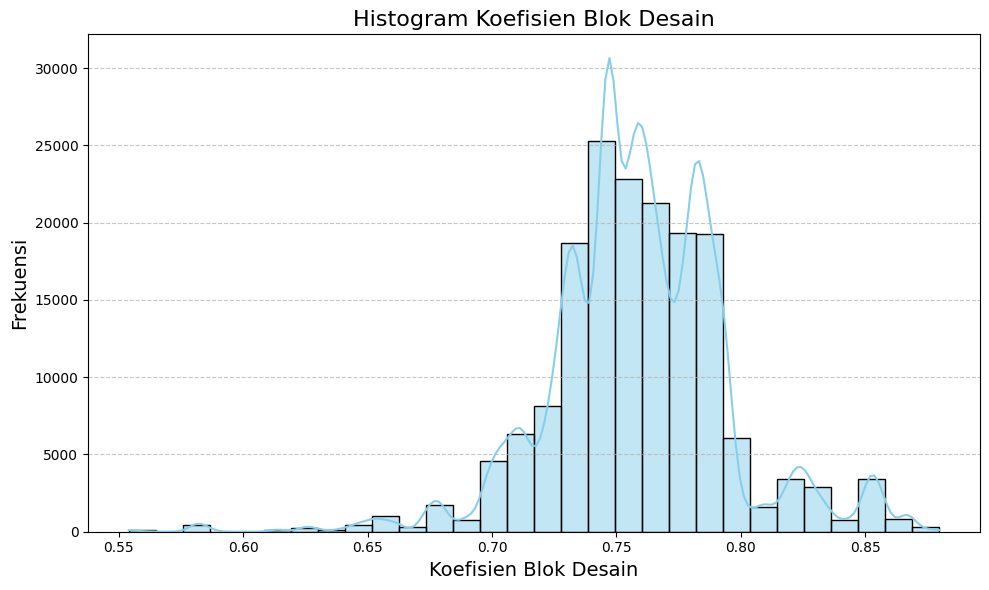

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["cbdesign"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Koefisien Blok Desain', fontsize=16)
plt.xlabel('Koefisien Blok Desain', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

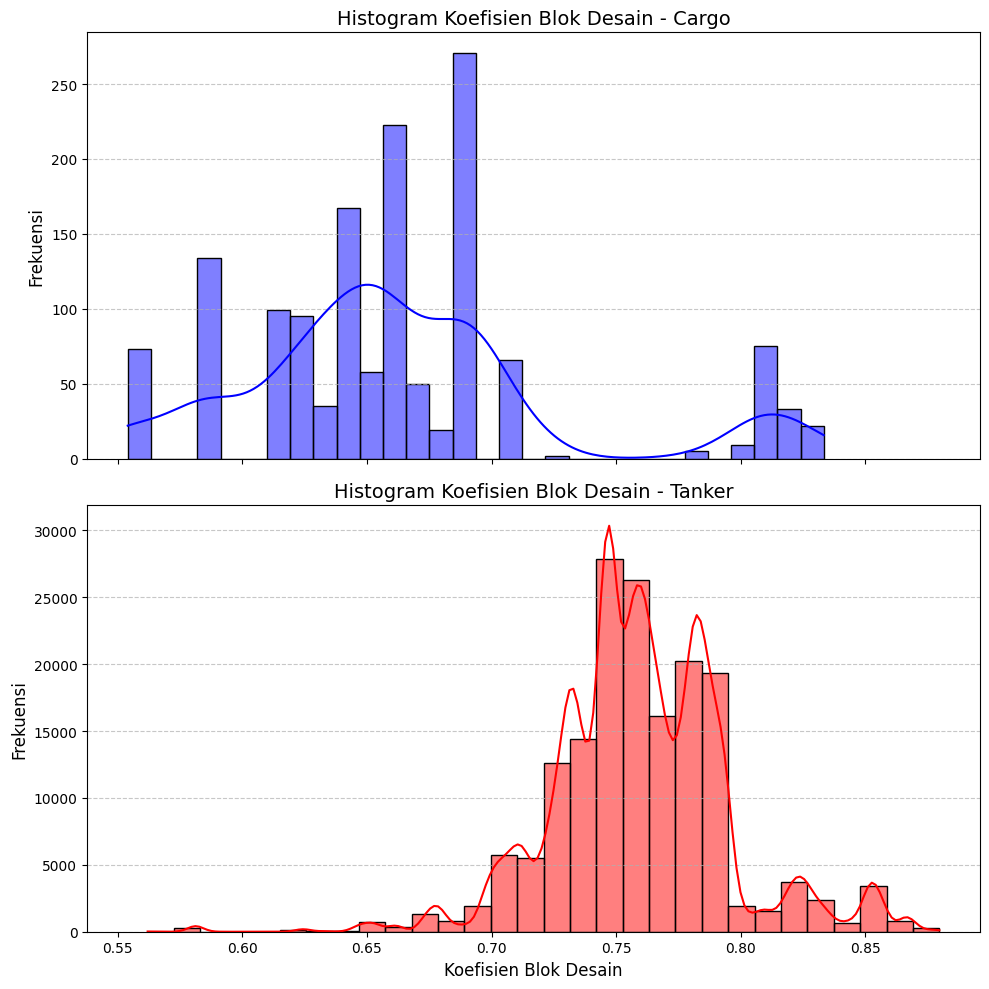

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat figure dengan 2 subplot (2 baris, 1 kolom) tanpa share y-axis
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=False)

# Histogram untuk Cargo
sns.histplot(imputed_cbd_pd[imputed_cbd_pd["vessel_type"] == "Cargo"], 
             x="cbdesign", bins=30, kde=True, color='blue', edgecolor='black', ax=axes[0])
axes[0].set_title("Histogram Koefisien Blok Desain - Cargo", fontsize=14)
axes[0].set_xlabel("Koefisien Blok Desain", fontsize=12)
axes[0].set_ylabel("Frekuensi", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram untuk Tanker
sns.histplot(imputed_cbd_pd[imputed_cbd_pd["vessel_type"] == "Tanker"], 
             x="cbdesign", bins=30, kde=True, color='red', edgecolor='black', ax=axes[1])
axes[1].set_title("Histogram Koefisien Blok Desain - Tanker", fontsize=14)
axes[1].set_xlabel("Koefisien Blok Desain", fontsize=12)
axes[1].set_ylabel("Frekuensi", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Atur layout agar tidak tumpang tindih
plt.tight_layout()
plt.show()

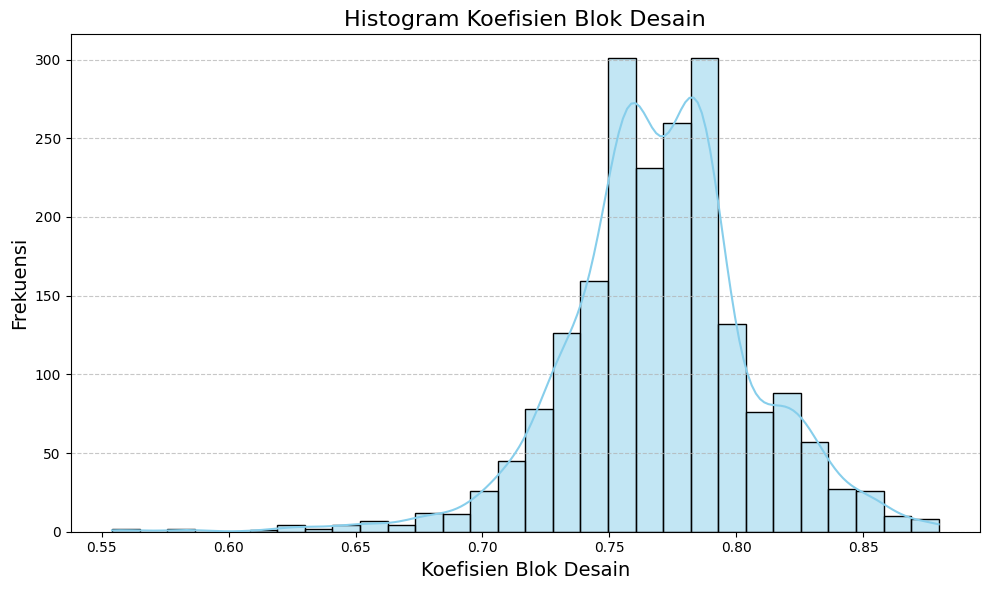

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya MMSI unik
unique_mmsi_df = imputed_cbd_pd.drop_duplicates(subset="mmsi")

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(unique_mmsi_df["cbdesign"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Koefisien Blok Desain', fontsize=16)
plt.xlabel('Koefisien Blok Desain', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

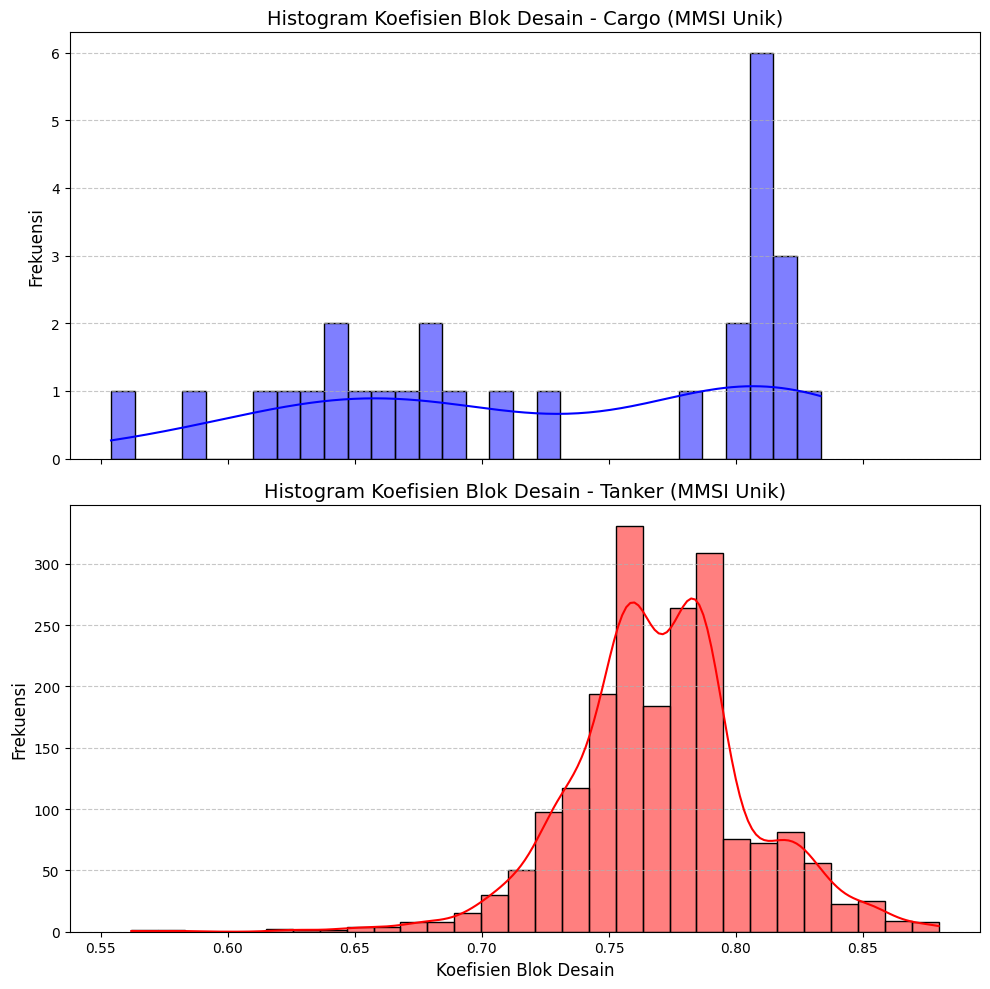

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hanya MMSI unik
unique_mmsi_df = imputed_cbd_pd.drop_duplicates(subset="mmsi")

# Buat figure dengan 2 subplot (2 baris, 1 kolom) tanpa share y-axis
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, sharey=False)

# Histogram untuk Cargo
sns.histplot(unique_mmsi_df[unique_mmsi_df["vessel_type"] == "Cargo"], 
             x="cbdesign", bins=30, kde=True, color='blue', edgecolor='black', ax=axes[0])
axes[0].set_title("Histogram Koefisien Blok Desain - Cargo (MMSI Unik)", fontsize=14)
axes[0].set_xlabel("Koefisien Blok Desain", fontsize=12)
axes[0].set_ylabel("Frekuensi", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Histogram untuk Tanker
sns.histplot(unique_mmsi_df[unique_mmsi_df["vessel_type"] == "Tanker"], 
             x="cbdesign", bins=30, kde=True, color='red', edgecolor='black', ax=axes[1])
axes[1].set_title("Histogram Koefisien Blok Desain - Tanker (MMSI Unik)", fontsize=14)
axes[1].set_xlabel("Koefisien Blok Desain", fontsize=12)
axes[1].set_ylabel("Frekuensi", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Atur layout agar tidak tumpang tindih
plt.tight_layout()
plt.show()

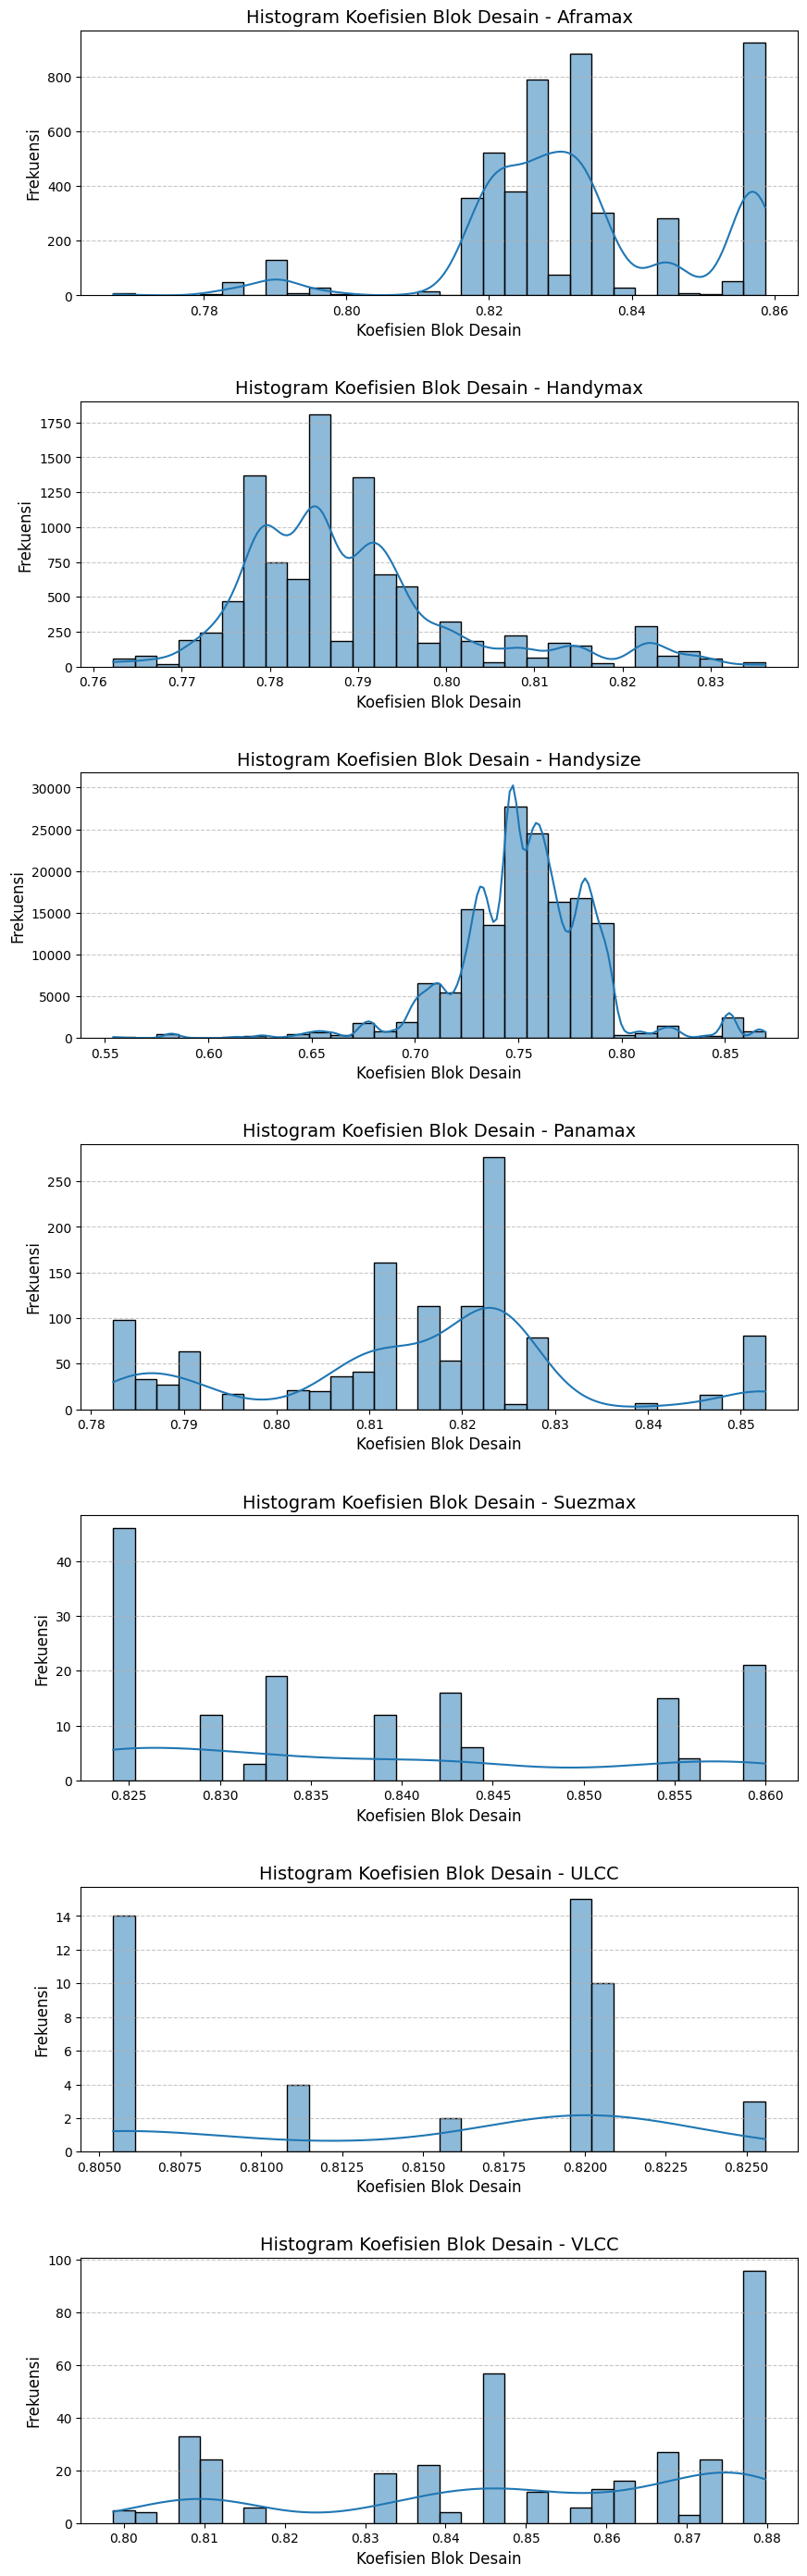

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dapatkan daftar unik kelas_kapal
kelas_list = imputed_cbd_pd["kelas_kapal"].unique()

# Tentukan jumlah subplot berdasarkan jumlah kelas_kapal
n_kelas = len(kelas_list)
fig, axes = plt.subplots(n_kelas, 1, figsize=(10, 5 * n_kelas), sharex=False, sharey=False)  # Tidak share sumbu

# Jika hanya ada satu kelas_kapal, pastikan axes tetap array agar bisa di-loop
if n_kelas == 1:
    axes = [axes]

# Loop untuk setiap kelas_kapal dan buat histogramnya
for i, kelas in enumerate(kelas_list):
    ax = axes[i]
    data_kelas = imputed_cbd_pd[imputed_cbd_pd["kelas_kapal"] == kelas]

    # Plot histogram tanpa share axis
    sns.histplot(data_kelas, x="cbdesign", bins=30, kde=True, edgecolor='black', ax=ax)

    # Atur judul dan label sumbu
    ax.set_title(f"Histogram Koefisien Blok Desain - {kelas}", fontsize=14)
    ax.set_xlabel("Koefisien Blok Desain", fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan ruang antar subplot agar label tidak bertumpuk
plt.subplots_adjust(hspace=0.4)

# Tampilkan plot
plt.show()

In [37]:
imputed_cbd.groupBy("vessel_type").count().show()

+-----------+------+
|vessel_type| count|
+-----------+------+
|     Tanker|168647|
|      Cargo|  1436|
+-----------+------+



In [38]:
imputed_cbd.groupBy("kelas_kapal").count().show()

+-----------+------+
|kelas_kapal| count|
+-----------+------+
|  Handysize|153079|
|    Panamax|  1262|
|       ULCC|    48|
|    Suezmax|   154|
|   Handymax| 10316|
|    Aframax|  4853|
|       VLCC|   371|
+-----------+------+



## Periksa Summer Draught

In [23]:
from pyspark.sql.functions import col, countDistinct

# Filter SummerDraught == 0
filtered_data = imputed_cbd.filter(col("SummerDraught") == 0)

# Hitung jumlah record
record_count = filtered_data.count()
print(f"Jumlah record dengan SummerDraught = 0: {record_count}")

# Hitung jumlah MMSI unik
unique_mmsi_count = filtered_data.select("mmsi").distinct().count()
print(f"Jumlah MMSI unik: {unique_mmsi_count}")

# Tampilkan data berdasarkan MMSI unik
filtered_data.select("mmsi","Deadweight","LBP","BreadthMoulded","GrossTonnage","SummerDraught").distinct().show(n=100, truncate=False)

Jumlah record dengan SummerDraught = 0: 4692
Jumlah MMSI unik: 21
+---------+----------+-----+--------------+------------+-------------+
|mmsi     |Deadweight|LBP  |BreadthMoulded|GrossTonnage|SummerDraught|
+---------+----------+-----+--------------+------------+-------------+
|525119034|2200.0    |90.0 |15.0          |2432        |0.0          |
|525015818|500.0     |44.0 |8.0           |313         |0.0          |
|525023356|2250.0    |58.2 |16.0          |1148        |0.0          |
|525023236|5791.0    |74.68|19.5          |2180        |0.0          |
|525300475|1000.0    |53.19|12.0          |664         |0.0          |
|525019637|2500.0    |74.5 |15.24         |1222        |0.0          |
|525010327|3915.0    |72.32|18.0          |1997        |0.0          |
|525010168|3540.0    |84.07|20.0          |2370        |0.0          |
|525021305|3500.0    |88.28|15.0          |1975        |0.0          |
|525006108|1900.0    |70.0 |11.2          |995         |0.0          |
|677042300|

In [24]:
# Buat df baru dengan rename kolom
renamed_cbd = imputed_cbd.withColumnRenamed("SummerDraught", "dmax") \
                              .withColumnRenamed("draught", "dreported")

# Tampilkan skema untuk memastikan perubahan
renamed_cbd.printSchema()

root
 |-- mmsi: integer (nullable = true)
 |-- imo: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- dt_pos_utc: timestamp (nullable = true)
 |-- H3_int_index_8: long (nullable = true)
 |-- vessel_type: string (nullable = true)
 |-- ShiptypeLevel5: string (nullable = true)
 |-- length: double (nullable = true)
 |-- width: double (nullable = true)
 |-- dreported: double (nullable = true)
 |-- sog: double (nullable = true)
 |-- nav_status: string (nullable = true)
 |-- prov: string (nullable = true)
 |-- kabkot: string (nullable = true)
 |-- Port: string (nullable = true)
 |-- boundary_h3: long (nullable = true)
 |-- position: string (nullable = true)
 |-- GrossTonnage: integer (nullable = true)
 |-- Deadweight: double (nullable = true)
 |-- dmax: double (nullable = true)
 |-- LBP: double (nullable = true)
 |-- LOA: double (nullable = true)
 |-- BreadthMoulded: double (nullable = true)
 |-- BreadthExtreme: double (nullable = 

In [25]:
from pyspark.sql.functions import col, sqrt, when, max

# Cari nilai dreported tertinggi untuk setiap mmsi
max_dreported = renamed_cbd.groupBy("mmsi").agg(max("dreported").alias("max_dreported"))

# Gabungkan dengan data asli dan perbarui dmax jika lebih kecil dari max_dreported
imputed_sd = renamed_cbd.join(max_dreported, on="mmsi", how="left").withColumn(
    "dmax", when(col("dmax") < col("max_dreported"), col("max_dreported")).otherwise(col("dmax"))
).drop("max_dreported")

# Cek hasil dengan memfilter jika masih ada dmax < dreported
imputed_sd.filter(col("dmax") < col("dreported")).show(truncate=False)

Error while receiving.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=60>
Closing down clientserver connection
Closing down clientserver connection


ERROR: Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=60>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR: KeyboardInterrupt while

KeyboardInterrupt: 

In [41]:
from pyspark.sql.functions import col

# Simpan data sebelum imputasi (data dengan draught = 0)
before_imputation = filtered_data.select("mmsi", "SummerDraught")

# Gabungkan data sebelum imputasi dengan data setelah imputasi
comparison = before_imputation.join(imputed_sd.select("mmsi", "SummerDraught"), "mmsi", "inner")

# Tampilkan hasil perbandingan
comparison.withColumnRenamed("SummerDraught", "draught_before") \
          .withColumnRenamed("SummerDraught", "draught_after") \
          .show(truncate=False)

+---------+--------------+-----------------+
|mmsi     |draught_before|draught_before   |
+---------+--------------+-----------------+
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818|0.0           |6.319956024626224|
|525015818

In [ ]:
# Tampilkan hasil untuk verifikasi
imputed_sd.filter(F.col("SummerDraught") == 0).show(truncate=False)

In [40]:
from pyspark.sql.functions import col, avg, when

# Mapping pertama: Imputasi berdasarkan Deadweight
mapping_df_deadweight = (
    imputed_sd.filter(col("SummerDraught") > 0)
    .groupBy("Deadweight")
    .agg(avg("SummerDraught").alias("avg_SummerDraught_dw"))
)

# Mapping kedua: Imputasi berdasarkan cbdesign
mapping_df_cbdesign = (
    imputed_sd.filter(col("SummerDraught") > 0)
    .groupBy("cbdesign")
    .agg(avg("SummerDraught").alias("avg_SummerDraught_cb"))
)

# Mapping ketiga: Imputasi berdasarkan kelas_kapal
mapping_df_kelas_kapal = (
    imputed_sd.filter(col("SummerDraught") > 0)
    .groupBy("kelas_kapal")
    .agg(avg("SummerDraught").alias("avg_SummerDraught_kelas"))
)

# Gabungkan semua mapping ke data utama
imputed_data_ais = (
    imputed_sd
    # Join dengan mapping Deadweight
    .join(mapping_df_deadweight, "Deadweight", "left")
    # Join dengan mapping cbdesign
    .join(mapping_df_cbdesign, "cbdesign", "left")
    # Join dengan mapping kelas_kapal
    .join(mapping_df_kelas_kapal, "kelas_kapal", "left")
    # Imputasi bertahap
    .withColumn(
        "SummerDraught",
        when(col("SummerDraught") == 0,
            when(col("avg_SummerDraught_dw").isNotNull(), col("avg_SummerDraught_dw"))
            .otherwise(
                when(col("avg_SummerDraught_cb").isNotNull(), col("avg_SummerDraught_cb"))
                .otherwise(col("avg_SummerDraught_kelas"))
            )
        ).otherwise(col("SummerDraught"))
    )
    # Hapus kolom tambahan setelah imputasi selesai
    .drop("avg_SummerDraught_dw", "avg_SummerDraught_cb", "avg_SummerDraught_kelas")
)

# Tampilkan hasil untuk verifikasi
imputed_data_ais.filter(F.col("SummerDraught") == 0).show(truncate=False)

+-----------+--------+----------+----+---+---------+--------+----------+--------------+-----------+--------------+------------+-------------+------+-----+---+---+--------------+--------------+-------+---+----------+-----+----+------+----+-----------+--------+
|kelas_kapal|cbdesign|Deadweight|mmsi|imo|longitude|latitude|dt_pos_utc|H3_int_index_8|vessel_type|ShiptypeLevel5|GrossTonnage|SummerDraught|length|width|LBP|LOA|BreadthMoulded|BreadthExtreme|draught|sog|nav_status|speed|prov|kabkot|Port|boundary_h3|position|
+-----------+--------+----------+----+---+---------+--------+----------+--------------+-----------+--------------+------------+-------------+------+-----+---+---+--------------+--------------+-------+---+----------+-----+----+------+----+-----------+--------+
+-----------+--------+----------+----+---+---------+--------+----------+--------------+-----------+--------------+------------+-------------+------+-----+---+---+--------------+--------------+-------+---+----------+-----

## Eksplor Draught

In [44]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_data_ais_pd = imputed_data_ais.select("mmsi", "vessel_type", "kelas_kapal", "dmax", "dreported").toPandas()

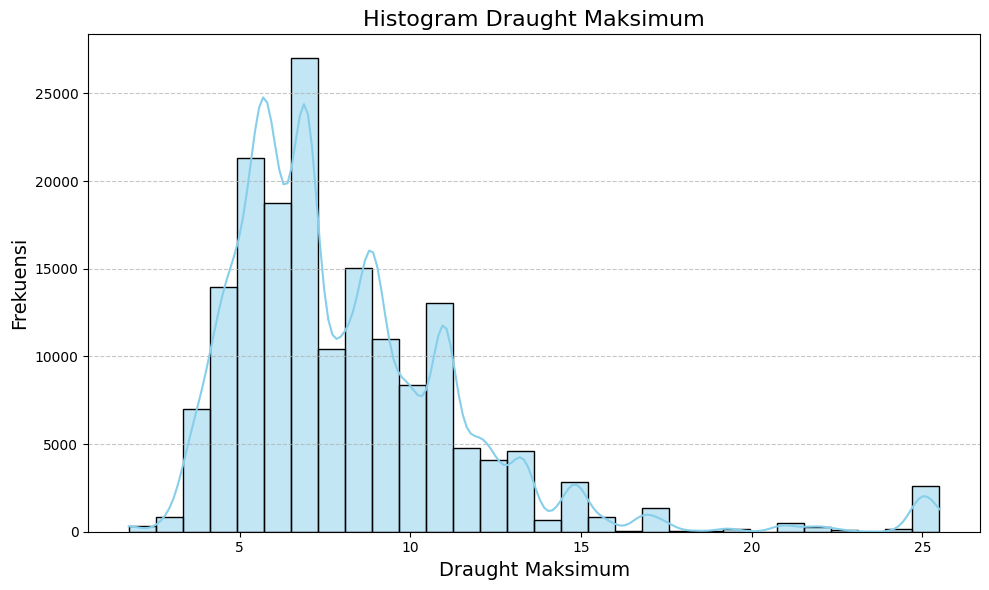

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_data_ais_pd["dmax"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Draught Maksimum', fontsize=16)
plt.xlabel('Draught Maksimum', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

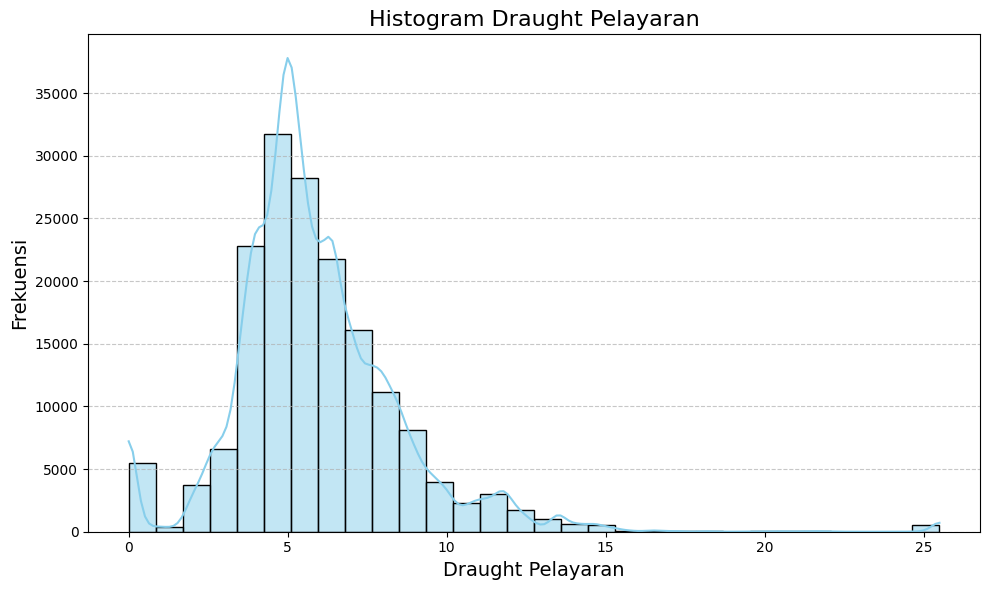

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_data_ais_pd["dreported"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Draught Pelayaran', fontsize=16)
plt.xlabel('Draught Pelayaran', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

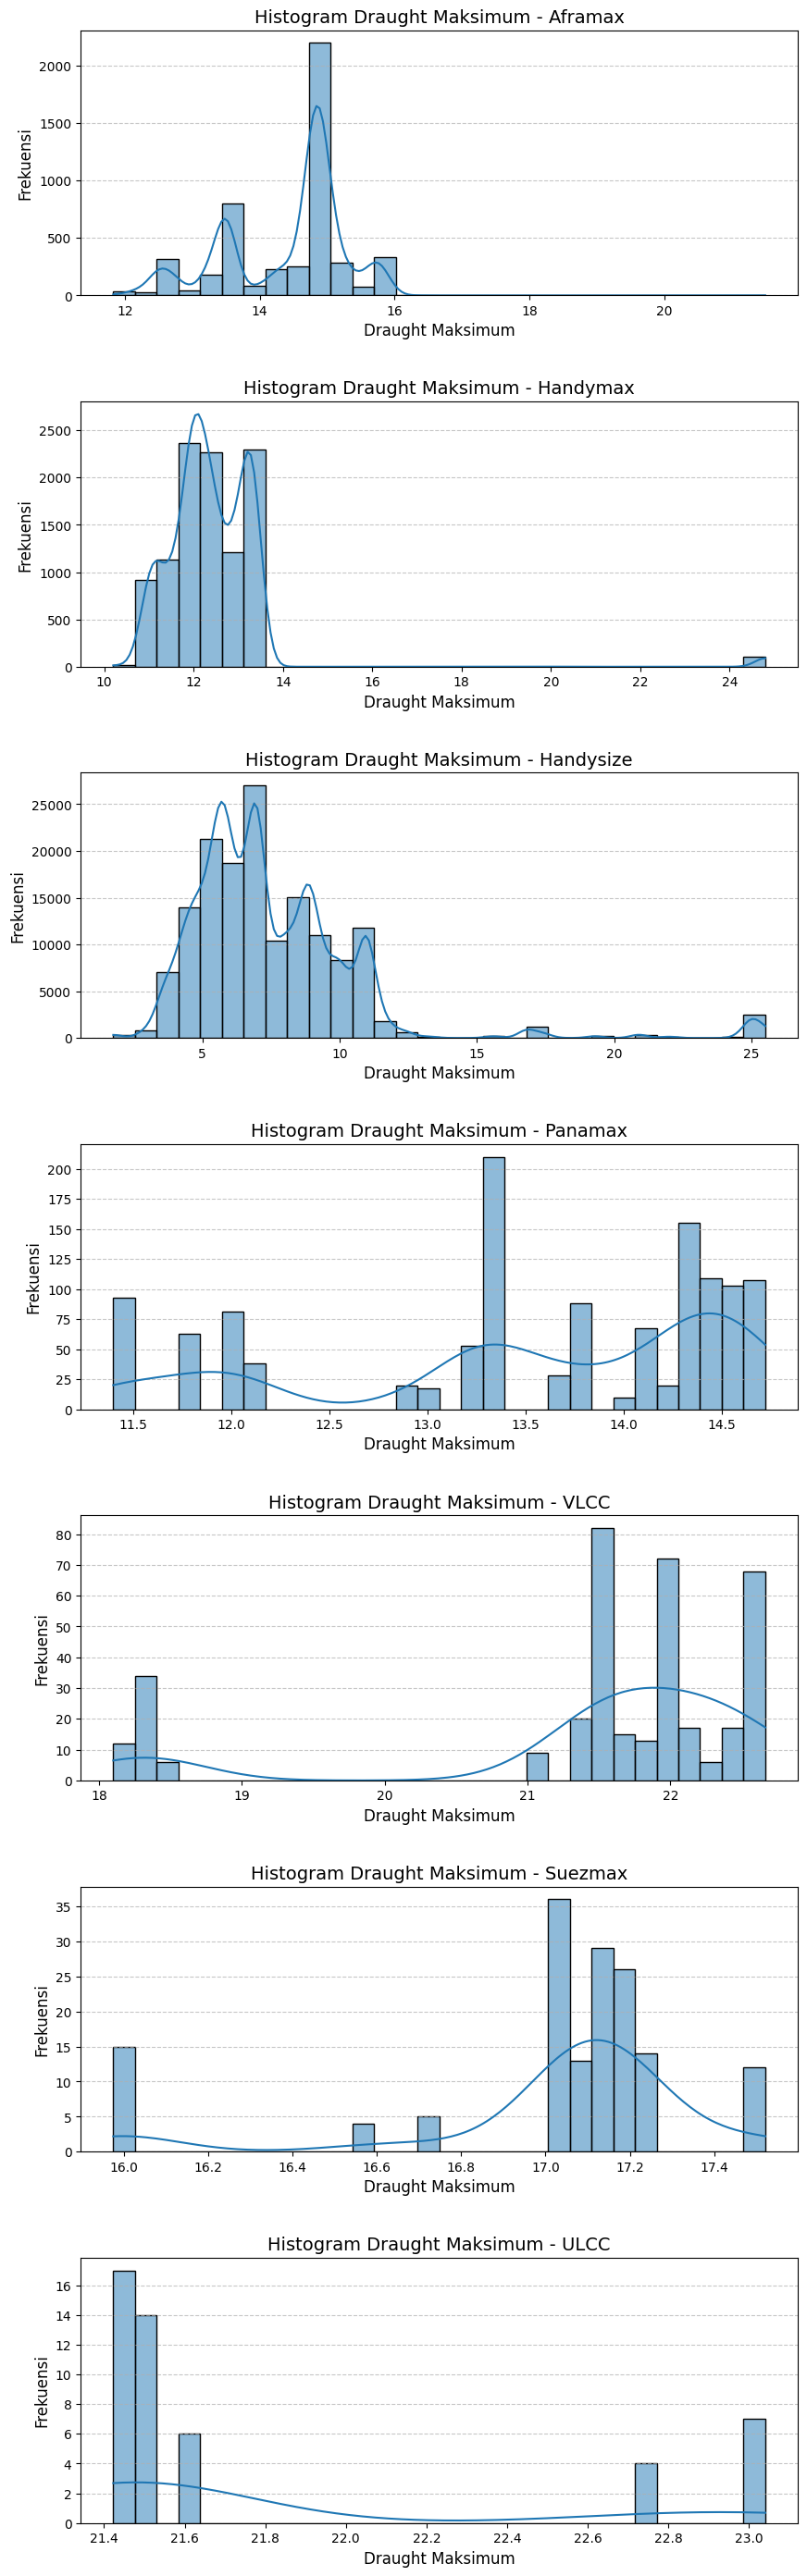

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dapatkan daftar unik kelas_kapal
kelas_list = imputed_data_ais_pd["kelas_kapal"].unique()

# Tentukan jumlah subplot berdasarkan jumlah kelas_kapal
n_kelas = len(kelas_list)
fig, axes = plt.subplots(n_kelas, 1, figsize=(10, 5 * n_kelas), sharex=False, sharey=False)  # Tidak share sumbu

# Jika hanya ada satu kelas_kapal, pastikan axes tetap array agar bisa di-loop
if n_kelas == 1:
    axes = [axes]

# Loop untuk setiap kelas_kapal dan buat histogramnya
for i, kelas in enumerate(kelas_list):
    ax = axes[i]
    data_kelas = imputed_data_ais_pd[imputed_data_ais_pd["kelas_kapal"] == kelas]

    # Plot histogram tanpa share axis
    sns.histplot(data_kelas, x="dmax", bins=30, kde=True, edgecolor='black', ax=ax)

    # Atur judul dan label sumbu
    ax.set_title(f"Histogram Draught Maksimum - {kelas}", fontsize=14)
    ax.set_xlabel("Draught Maksimum", fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan ruang antar subplot agar label tidak bertumpuk
plt.subplots_adjust(hspace=0.4)

# Tampilkan plot
plt.show()

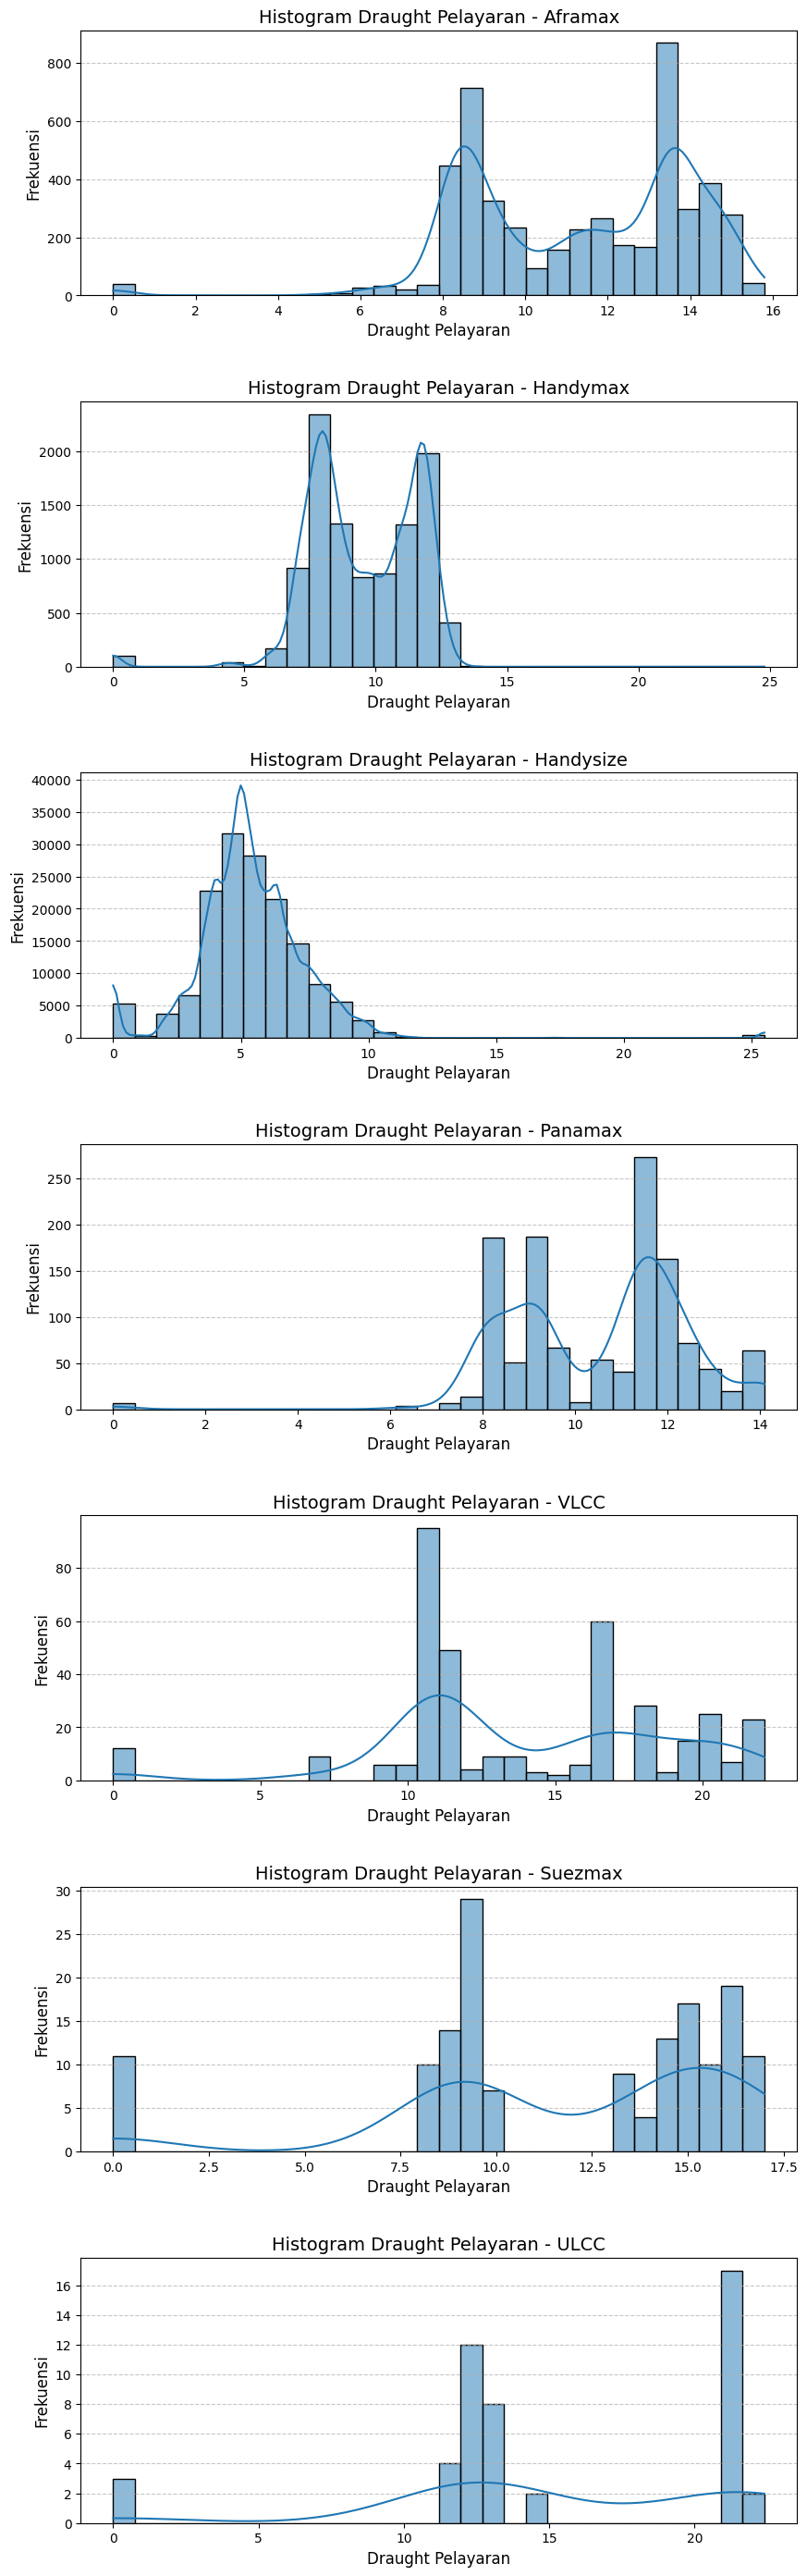

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dapatkan daftar unik kelas_kapal
kelas_list = imputed_data_ais_pd["kelas_kapal"].unique()

# Tentukan jumlah subplot berdasarkan jumlah kelas_kapal
n_kelas = len(kelas_list)
fig, axes = plt.subplots(n_kelas, 1, figsize=(10, 5 * n_kelas), sharex=False, sharey=False)  # Tidak share sumbu

# Jika hanya ada satu kelas_kapal, pastikan axes tetap array agar bisa di-loop
if n_kelas == 1:
    axes = [axes]

# Loop untuk setiap kelas_kapal dan buat histogramnya
for i, kelas in enumerate(kelas_list):
    ax = axes[i]
    data_kelas = imputed_data_ais_pd[imputed_data_ais_pd["kelas_kapal"] == kelas]

    # Plot histogram tanpa share axis
    sns.histplot(data_kelas, x="dreported", bins=30, kde=True, edgecolor='black', ax=ax)

    # Atur judul dan label sumbu
    ax.set_title(f"Histogram Draught Pelayaran - {kelas}", fontsize=14)
    ax.set_xlabel("Draught Pelayaran", fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan ruang antar subplot agar label tidak bertumpuk
plt.subplots_adjust(hspace=0.4)

# Tampilkan plot
plt.show()

In [49]:
# Filter data di mana dmax < dreported
filtered_data = imputed_data_ais.filter(imputed_data_ais["dmax"] < imputed_data_ais["dreported"])

# Hitung jumlah data yang memenuhi kondisi
jumlah_data = filtered_data.count()

# Tampilkan hasil
print(f"Jumlah data di mana dmax < dreported: {jumlah_data}")

Jumlah data di mana dmax < dreported: 0


In [52]:
from pyspark.sql.functions import col

# Hitung jumlah baris dengan dreported < 0.5
count_dreported_less_than_1 = imputed_data_ais.filter(col("dreported") < 1).count()

# Tampilkan hasil
print(f"Jumlah data dengan dreported < 0.5: {count_dreported_less_than_1}")

Jumlah data dengan dreported < 0.5: 5492


In [53]:
imputed_data_ais.filter(col("dreported") < 1).show(n=10000)

+---------+-----------+------------------+-----------------+-------+------------------+--------------------+-------------------+------------------+-----------+--------------------+------------+-----------------+------+-----+------------------+-------+--------------+--------------+---------+----+--------------------+------------------+--------------------+--------------------+--------------------+------------------+--------+
|     mmsi|kelas_kapal|          cbdesign|       Deadweight|    imo|         longitude|            latitude|         dt_pos_utc|    H3_int_index_8|vessel_type|      ShiptypeLevel5|GrossTonnage|             dmax|length|width|               LBP|    LOA|BreadthMoulded|BreadthExtreme|dreported| sog|          nav_status|             speed|                prov|              kabkot|                Port|       boundary_h3|position|
+---------+-----------+------------------+-----------------+-------+------------------+--------------------+-------------------+----------------

## Bentuk Reported Block Coefficient

In [57]:
from pyspark.sql.functions import col, pow, lit, when

# Membuat kolom cbreported dengan rumus yang benar
imputed_data_ais = imputed_data_ais.withColumn(
    "cbreported",
    when(
        col("dreported") >= 1,  # Menghindari pembagian dengan 0
        lit(1) - ((lit(1) - col("cbdesign")) * pow((col("dmax") / col("dreported")), lit(1) / 3))
    ).otherwise(1)  # Isi 1 jika dreported tidak valid
)

# Tampilkan beberapa data untuk verifikasi
imputed_data_ais.select("cbdesign", "dmax", "dreported", "cbreported").show()

+------------------+------+---------+------------------+
|          cbdesign|  dmax|dreported|        cbreported|
+------------------+------+---------+------------------+
|0.7910627954940119|12.522|      9.4|0.7701041870180679|
|0.7910627954940119|12.522|      9.4|0.7701041870180679|
|0.7910627954940119|12.522|      9.4|0.7701041870180679|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.5|0.7850482099709594|
|0.7910627954940119|12.522|     11.7|0.7862800524341278|
|0.7910627954940119|12.522|     11.7|0.7862800524341278|
|0.7910627954940119|12.522|    

In [58]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = imputed_data_ais.select("mmsi", "vessel_type", "kelas_kapal","cbreported").toPandas()

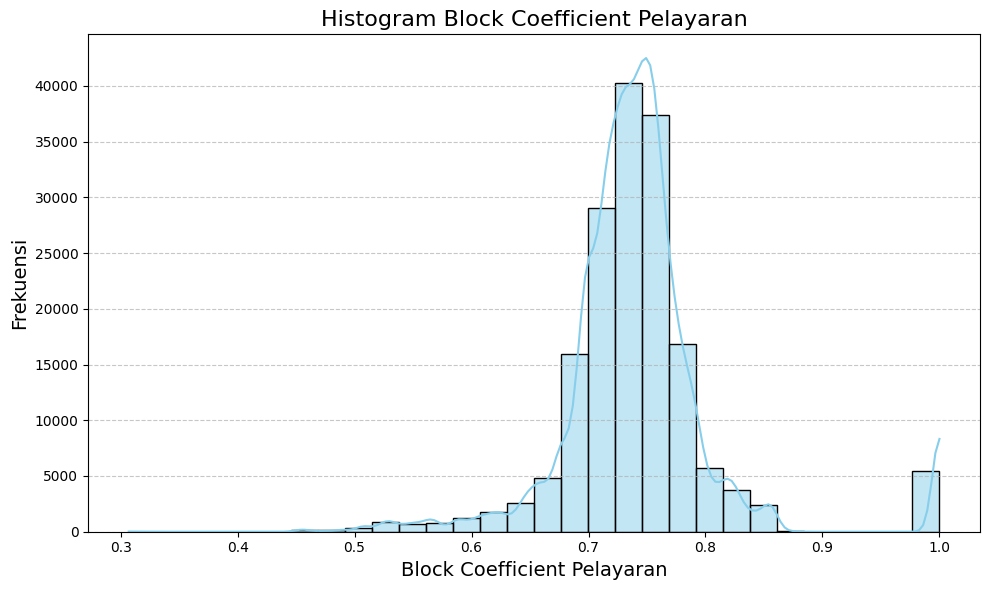

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["cbreported"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Block Coefficient Pelayaran', fontsize=16)
plt.xlabel('Block Coefficient Pelayaran', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

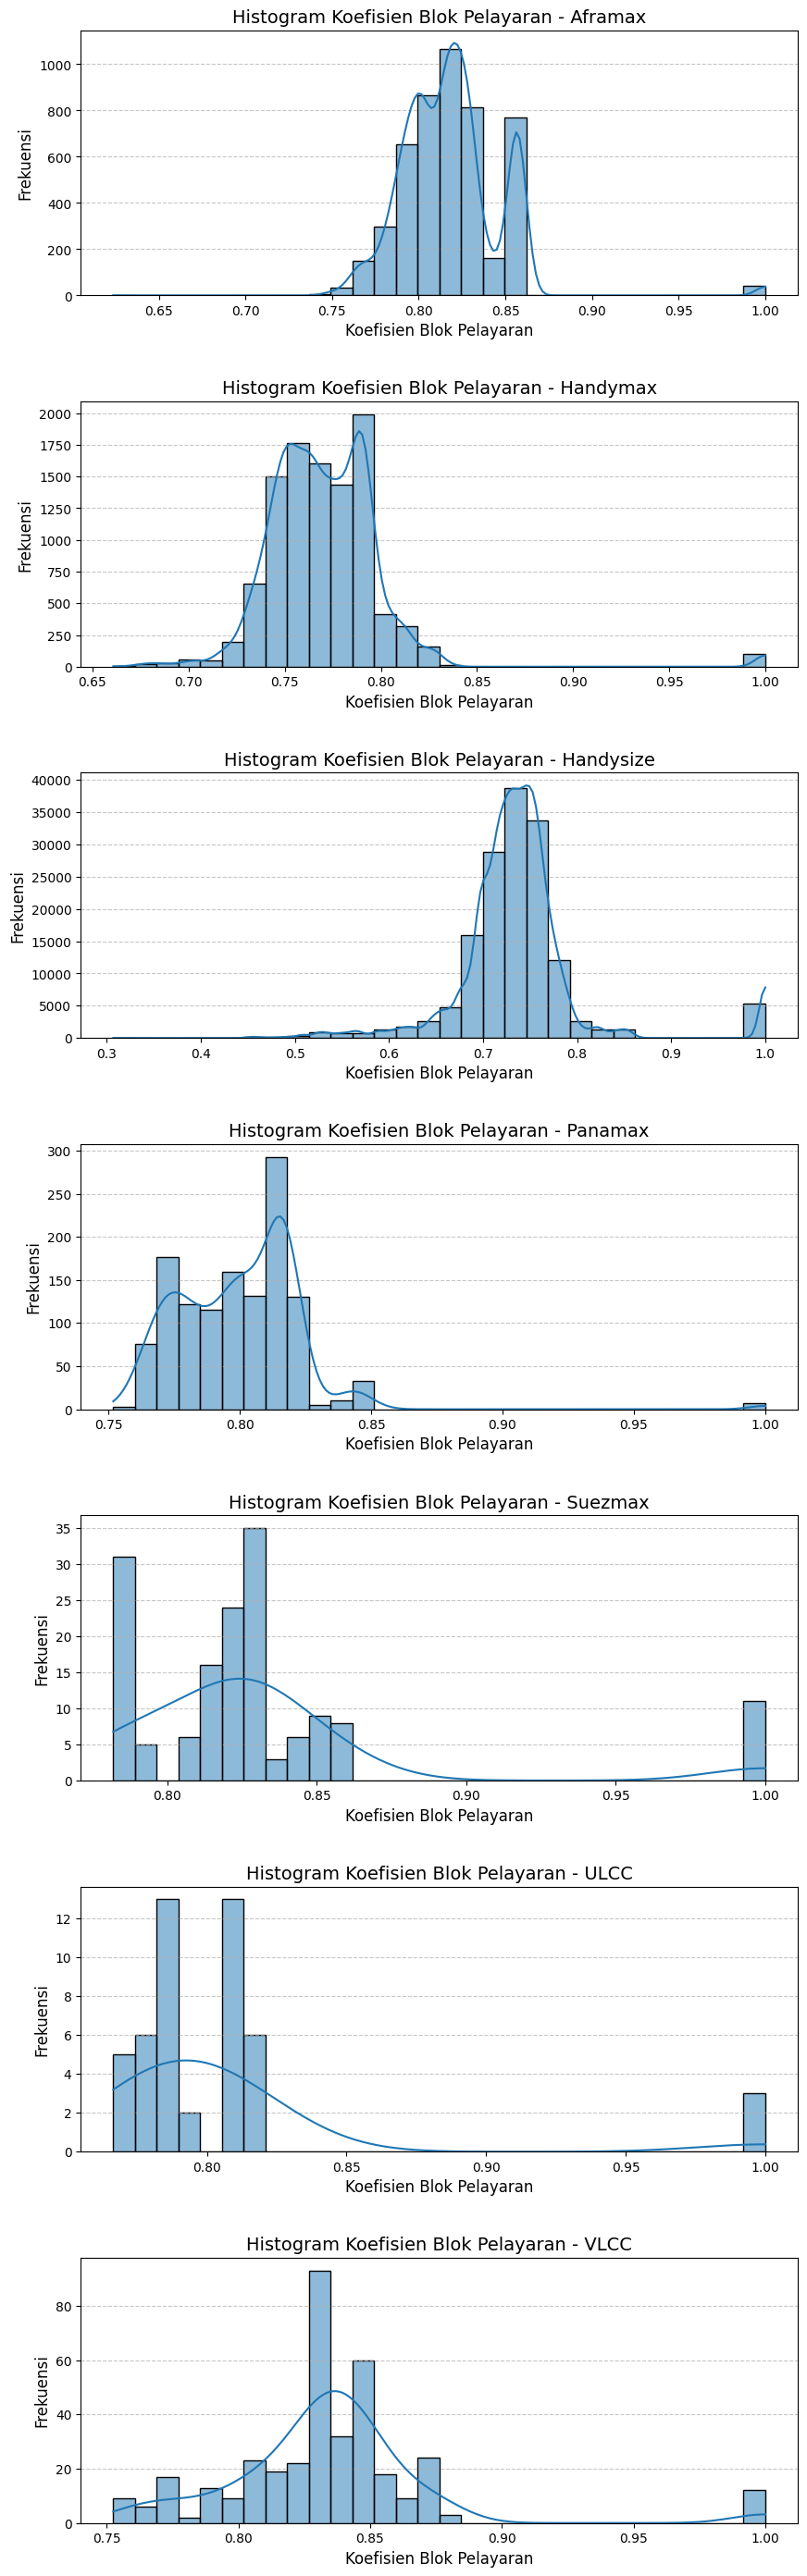

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dapatkan daftar unik kelas_kapal
kelas_list = imputed_cbd_pd["kelas_kapal"].unique()

# Tentukan jumlah subplot berdasarkan jumlah kelas_kapal
n_kelas = len(kelas_list)
fig, axes = plt.subplots(n_kelas, 1, figsize=(10, 5 * n_kelas), sharex=False, sharey=False)  # Tidak share sumbu

# Jika hanya ada satu kelas_kapal, pastikan axes tetap array agar bisa di-loop
if n_kelas == 1:
    axes = [axes]

# Loop untuk setiap kelas_kapal dan buat histogramnya
for i, kelas in enumerate(kelas_list):
    ax = axes[i]
    data_kelas = imputed_cbd_pd[imputed_cbd_pd["kelas_kapal"] == kelas]

    # Plot histogram tanpa share axis
    sns.histplot(data_kelas, x="cbreported", bins=30, kde=True, edgecolor='black', ax=ax)

    # Atur judul dan label sumbu
    ax.set_title(f"Histogram Koefisien Blok Pelayaran - {kelas}", fontsize=14)
    ax.set_xlabel("Koefisien Blok Pelayaran", fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan ruang antar subplot agar label tidak bertumpuk
plt.subplots_adjust(hspace=0.4)

# Tampilkan plot
plt.show()

In [61]:
print(f"5-Number Summary + Mean:")
five_number_summary_with_mean(imputed_data_ais, "cbreported")

5-Number Summary + Mean:
+-----------------+------------------+------------------+------------------+---+------------------+
|min              |Q1                |median            |Q3                |max|mean              |
+-----------------+------------------+------------------+------------------+---+------------------+
|0.306922302565397|0.7129237459378128|0.7385350292676882|0.7623250355834541|1.0|0.7415771418367438|
+-----------------+------------------+------------------+------------------+---+------------------+



In [63]:
imputed_data_ais.select("cbdesign", "dmax", "dreported", "cbreported").filter(col("cbreported") == 1).show(n=1000)

+------------------+-----------------+---------+----------+
|          cbdesign|             dmax|dreported|cbreported|
+------------------+-----------------+---------+----------+
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7987788575061544|           13.316|      0.0|       1.0|
|0.7868691683015934|           11.715|      0.0|       1.0|
|0.7030582990641815|              4.9|      0.0|       1.0|
|0.7560359708228628|             20.5|      0.0|       1.0|
|0.7673010158388944|              5.0|      0.0|       1.0|
|0.7334132977835208|            4.943|      0.0|       1.0|
|0.7334132977835208|            4.943|      0.0|       1.0|
|0.7334132977835208|            4.943|  

In [64]:
from pyspark.sql.functions import col, count

# Hitung jumlah berdasarkan kondisi
count_cbdesign_less = imputed_data_ais.filter(col("cbdesign") < col("cbreported")).count()
count_cbdesign_equal = imputed_data_ais.filter(col("cbdesign") == col("cbreported")).count()
count_cbdesign_greater = imputed_data_ais.filter(col("cbdesign") > col("cbreported")).count()

# Tampilkan hasil
print(f"Jumlah cbdesign < cbreported: {count_cbdesign_less}")
print(f"Jumlah cbdesign = cbreported: {count_cbdesign_equal}")
print(f"Jumlah cbdesign > cbreported: {count_cbdesign_greater}")

Jumlah cbdesign < cbreported: 5492
Jumlah cbdesign = cbreported: 14170
Jumlah cbdesign > cbreported: 150421


## Hitung Payload

In [60]:
from pyspark.sql.functions import col, count, when

# Daftar variabel yang akan dianalisis
variables = ["deadweight", "cbdesign", "cbreported", "LBP", "BreadthMoulded", "dmax", "dreported"]

# Periksa jumlah nilai null untuk setiap kolom
for column in variables:
    null_count = imputed_data_ais.filter(col(column).isNull()).count()
    print(f"Kolom '{column}' memiliki {null_count} nilai null.")

Kolom 'deadweight' memiliki 0 nilai null.
Kolom 'cbdesign' memiliki 0 nilai null.
Kolom 'cbreported' memiliki 0 nilai null.
Kolom 'LBP' memiliki 0 nilai null.
Kolom 'BreadthMoulded' memiliki 0 nilai null.
Kolom 'dmax' memiliki 0 nilai null.
Kolom 'dreported' memiliki 0 nilai null.


In [61]:
from pyspark.sql.functions import col, lit, when

# Definisikan densitas air laut
rho_w = 1.025

# Tambahkan kolom payload dengan memastikan nilai minimum adalah 0
data_ais_payload = imputed_data_ais.withColumn(
    "payload",
        ((col("cbreported") * col("dreported") - col("cbdesign") * col("dmax")) * 
         col("LBP") * col("BreadthMoulded") * lit(rho_w) + col("deadweight")) / col("deadweight")
)

# Tampilkan hasil untuk verifikasi
data_ais_payload.select(
    "mmsi", "cbreported", "cbdesign", "dreported", "dmax", 
    "LBP", "BreadthMoulded", "deadweight", "payload"
).show(n=100, truncate=False)

+---------+------------------+------------------+---------+------+-----+--------------+----------+-------------------+
|mmsi     |cbreported        |cbdesign          |dreported|dmax  |LBP  |BreadthMoulded|deadweight|payload            |
+---------+------------------+------------------+---------+------+-----+--------------+----------+-------------------+
|311000439|0.7759676356512941|0.7914747540900187|10.1     |12.525|275.0|48.94         |86044.0   |0.6671746173506479 |
|311000439|0.7759676356512941|0.7914747540900187|10.1     |12.525|275.0|48.94         |86044.0   |0.6671746173506479 |
|311000439|0.7759676356512941|0.7914747540900187|10.1     |12.525|275.0|48.94         |86044.0   |0.6671746173506479 |
|311000439|0.7737045293034774|0.7914747540900187|9.8      |12.525|275.0|48.94         |86044.0   |0.6262968791111068 |
|311000439|0.7737045293034774|0.7914747540900187|9.8      |12.525|275.0|48.94         |86044.0   |0.6262968791111068 |
|311000439|0.7737045293034774|0.7914747540900187

In [62]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Payload:")
five_number_summary_with_mean(data_ais_payload, "payload")

5-Number Summary + Mean for Payload:
+-------------------+------------------+------------------+------------------+---+------------------+
|min                |Q1                |median            |Q3                |max|mean              |
+-------------------+------------------+------------------+------------------+---+------------------+
|-10.215344689044022|0.4824556468023597|0.6647707912230729|0.8825963462189836|1.0|0.5018794972752867|
+-------------------+------------------+------------------+------------------+---+------------------+



In [72]:
# Menampilkan 5-number summary + rata-rata untuk payload yang < 0
print("5-Number Summary + Mean for Payload (payload < 0):")
five_number_summary_with_mean(data_ais_payload.filter(col("payload") < 0), "payload")

5-Number Summary + Mean for Payload (payload < 0):
+-------------------+-------------------+-------------------+-------------------+----------------------+------------------+
|min                |Q1                 |median             |Q3                 |max                   |mean              |
+-------------------+-------------------+-------------------+-------------------+----------------------+------------------+
|-10.215344689043597|-2.4223451404454286|-1.2514389401085135|-0.5062258122559323|-0.0038503880890543287|-1.811843380831068|
+-------------------+-------------------+-------------------+-------------------+----------------------+------------------+



In [74]:
# Menampilkan data dengan payload < 0 dan mengurutkan berdasarkan payload terkecil
print("Data dengan payload < 0 diurutkan berdasarkan payload terkecil:")
data_ais_payload.select(
    "mmsi", "cbreported", "cbdesign", "dreported", "dmax", 
    "LBP", "BreadthMoulded", "deadweight", "payload"
).filter(col("payload") < 0).orderBy(col("payload")).show(n=15000, truncate=False)

Data dengan payload < 0 diurutkan berdasarkan payload terkecil:
+---------+---------------------+------------------+---------+-----------------+-----------------+--------------+----------+----------------------+
|mmsi     |cbreported           |cbdesign          |dreported|dmax             |LBP              |BreadthMoulded|deadweight|payload               |
+---------+---------------------+------------------+---------+-----------------+-----------------+--------------+----------+----------------------+
|525014006|1.0                  |0.6931021947386022|0.0      |25.5             |66.0             |11.5          |1226.0    |-10.215344689045661   |
|525014006|1.0                  |0.7680572750596968|0.0      |25.5             |85.525           |15.0          |3502.0    |-6.354037720830804    |
|525014006|1.0                  |0.7680572750596968|0.0      |25.5             |85.525           |15.0          |3502.0    |-6.354037720830804    |
|525014006|1.0                  |0.7680572750596

In [63]:
from pyspark.sql.functions import col

# Hitung jumlah record dengan payload < 0
count_payload_negative = data_ais_payload.filter(col("payload") < 0).count()
print(f"Jumlah record dengan payload < 0: {count_payload_negative}")

# Hitung jumlah record dengan payload > 1
count_payload_above_one = data_ais_payload.filter(col("payload") > 1).count()
print(f"Jumlah record dengan payload > 1: {count_payload_above_one}")

# Hitung jumlah record dengan payload antara 0 dan 1 (inklusif)
count_payload_zero_to_one = data_ais_payload.filter((col("payload") >= 0) & (col("payload") <= 1)).count()
print(f"Jumlah record dengan payload antara 0 dan 1: {count_payload_zero_to_one}")

Jumlah record dengan payload < 0: 13248
Jumlah record dengan payload > 1: 0
Jumlah record dengan payload antara 0 dan 1: 156835


In [64]:
from pyspark.sql.functions import col

# Filter data dengan payload < 0
negative_payload_df = data_ais_payload.filter(col("payload") < 0)

# Hitung jumlah record dengan payload < 0
count_payload_negative = negative_payload_df.count()

# Ambil daftar MMSI unik untuk payload < 0
unique_mmsi_negative = negative_payload_df.select("mmsi").distinct().rdd.flatMap(lambda x: x).collect()

print(f"Jumlah record dengan payload < 0: {count_payload_negative}")
print(f"Daftar MMSI unik dengan payload < 0: {unique_mmsi_negative}")

# Filter data dengan payload > 1
above_one_payload_df = data_ais_payload.filter(col("payload") > 1)

# Hitung jumlah record dengan payload > 1
count_payload_above_one = above_one_payload_df.count()

# Ambil daftar MMSI unik untuk payload > 1
unique_mmsi_above_one = above_one_payload_df.select("mmsi").distinct().rdd.flatMap(lambda x: x).collect()

print(f"Jumlah record dengan payload > 1: {count_payload_above_one}")
print(f"Daftar MMSI unik dengan payload > 1: {unique_mmsi_above_one}")

Jumlah record dengan payload < 0: 13248
Daftar MMSI unik dengan payload < 0: [538008499, 538005773, 525100679, 370252000, 525007030, 525019324, 563058100, 538006590, 636092865, 538004919, 636018011, 525015818, 525900985, 525011117, 525014017, 525005338, 525020082, 311000918, 538004167, 248123000, 477938700, 538008314, 525100732, 373367000, 572757000, 538005781, 525800420, 525009287, 538004558, 525119035, 525015674, 525108002, 525500214, 525114041, 525900120, 525019395, 525019510, 538005774, 477685800, 525104002, 525010055, 538004486, 249882000, 525108008, 525010385, 567070500, 440625000, 311906000, 566306000, 477151100, 525005090, 636090168, 525020429, 525024274, 566105000, 525018194, 235089901, 351907000, 538006837, 211185000, 525200823, 525700851, 525016143, 440207000, 372419000, 525020109, 354536000, 538004904, 256694000, 257047370, 525300475, 525100736, 525010322, 636019152, 525023162, 525500606, 525130307, 372343000, 525022678, 636017831, 525009047, 538007904, 525010345, 373698000

In [65]:
from pyspark.sql.functions import col

# Daftar MMSI yang ingin ditampilkan
mmsi_list = [538005773, 525007030, 525019324, 538004919, 525014017, 525005338, 311000918, 525100732, 525119035, 525015674, 525108002, 525114041, 525104002, 525010385, 440625000, 525200823, 525020109, 372419000, 525100736, 525010322, 525023162, 525022678, 525010345, 525015815, 525119151, 525200097, 636092857, 636016728, 563098600, 370849000, 525012410, 518100122, 259138000, 477067600, 354996000, 563481000, 677042300, 538005822, 525010056, 563037600, 525008076, 525018195, 525010327, 525200460, 309885000, 353727000, 525007247, 525119034, 351541000, 525003095, 538004189, 636018926, 525008131, 525003425, 525015757, 574003580, 525008013, 525006037, 525023202, 538005771, 525200062, 525020420, 526052657, 525020372, 525008015, 525200948, 525007390, 525012109, 525008081, 351551000, 525300909, 563099800, 636014478, 563017300, 525200523, 525200437, 563006700, 525020044, 572307220, 525100306, 525003264, 525023354, 123456789, 525100681, 572295220, 533131107, 319673000, 525106001, 370883000, 525008094, 525006213, 525018008, 525008071, 525019630, 525007322, 525009077, 525015779, 525021119, 525017094, 525019602, 525010134, 636092935, 525004139, 671176100, 525006997, 525100434, 525008052, 525119107, 525119056, 525012038, 525018229, 525100987, 525023380, 525008068, 356284000, 525019637, 220641000, 219127000, 525200748, 525019669, 525014072, 525024302, 111150465, 351385000, 525008007, 525007017, 525107007, 525300304, 525114048, 525109001, 525121005, 525021304, 563037200, 219333000, 525018425, 229553000, 525008099, 525010410, 538003353, 525006108, 525119145, 525119127, 525119102, 525022337, 413376440, 356471000, 525006216, 525019522, 525016211, 577201000, 477413700, 564270000]

# Filter data berdasarkan MMSI dan kondisi payload < 0
filtered_data = data_ais_payload.filter(
    (col("mmsi").isin(mmsi_list)) & (col("payload") < 0)
)

# Tampilkan hasil
filtered_data.select(
    "mmsi", "cbreported", "cbdesign", "dreported", "dmax", "LBP", "BreadthMoulded", "deadweight", "payload"
).show(n=10000, truncate=False)

+---------+---------------------+------------------+---------+-----------------+------------------+--------------+----------+---------------------+
|mmsi     |cbreported           |cbdesign          |dreported|dmax             |LBP               |BreadthMoulded|deadweight|payload              |
+---------+---------------------+------------------+---------+-----------------+------------------+--------------+----------+---------------------+
|538005773|1.0                  |0.7868691683015934|0.0      |11.715           |176.0             |27.4          |38506.0   |-0.18332355957238683 |
|525007030|1.0                  |0.7673010158388944|0.0      |5.0              |84.97             |15.0          |3557.0    |-0.40907028040609955 |
|525019324|1.0                  |0.7334132977835208|0.0      |4.943            |74.5              |11.5          |2254.0    |-0.4124186949066678  |
|525019324|1.0                  |0.7334132977835208|0.0      |4.943            |74.5              |11.5         

In [67]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = data_ais_payload.select("payload").toPandas()

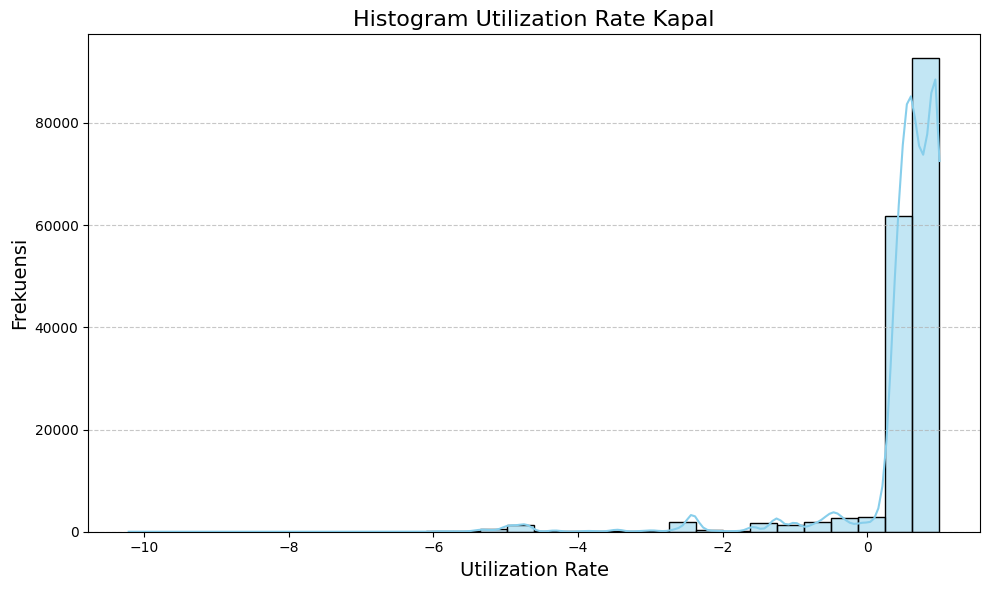

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["payload"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Utilization Rate Kapal', fontsize=16)
plt.xlabel('Utilization Rate', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

In [65]:
# Hitung jumlah record dengan payload > 1.5
count_payload_above_one = data_ais_payload.filter(col("payload") > 1.5).count()
print(f"Jumlah record dengan payload > 1.5: {count_payload_above_one}")

Jumlah record dengan payload > 1.5: 1197


## Imputasi Payload Negatif

In [75]:
from pyspark.sql.functions import col, when

# Tambahkan kolom payload dengan memastikan nilai minimum adalah 0
imputed_payload = data_ais_payload.withColumn(
    "payload",
    when(col("payload") < 0, 0).otherwise(col("payload"))  # Perbaikan kondisi
)

# Tampilkan hasil untuk verifikasi
imputed_payload.select(
    "mmsi", "cbreported", "cbdesign", "dreported", "dmax", 
    "LBP", "BreadthMoulded", "deadweight", "payload"
).show(n=100, truncate=False)

+---------+------------------+-----------------+---------+------+-----+--------------+----------+-------------------+
|mmsi     |cbreported        |cbdesign         |dreported|dmax  |LBP  |BreadthMoulded|deadweight|payload            |
+---------+------------------+-----------------+---------+------+-----+--------------+----------+-------------------+
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5      |14.798|235.0|42.0          |106650.0  |0.4746714169819886 |
|525800206|0.8000474908791215|0.833786806985983|8.5     

In [76]:
# Menampilkan 5-number summary + rata-rata untuk setiap variabel
print(f"5-Number Summary + Mean for Payload:")
five_number_summary_with_mean(imputed_payload, "payload")

5-Number Summary + Mean for Payload:
+---+------------------+------------------+------------------+---+------------------+
|min|Q1                |median            |Q3                |max|mean              |
+---+------------------+------------------+------------------+---+------------------+
|0.0|0.4824556468023597|0.6647707912230837|0.8825963462189836|1.0|0.6432110777701452|
+---+------------------+------------------+------------------+---+------------------+



In [77]:
# Konversi PySpark DataFrame ke Pandas DataFrame
imputed_cbd_pd = imputed_payload.select("vessel_type", "kelas_kapal", "payload").toPandas()

Error while receiving.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=71>
Closing down clientserver connection
Closing down clientserver connection


ERROR: Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=71>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR: KeyboardInterrupt while

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(imputed_cbd_pd["payload"], bins=30, kde=True, color='skyblue', edgecolor='black')

# Tambahkan judul dan label
plt.title('Histogram Utilization Rate Kapal', fontsize=16)
plt.xlabel('Utilization Rate', fontsize=14)
plt.ylabel('Frekuensi', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.tight_layout()
plt.show()

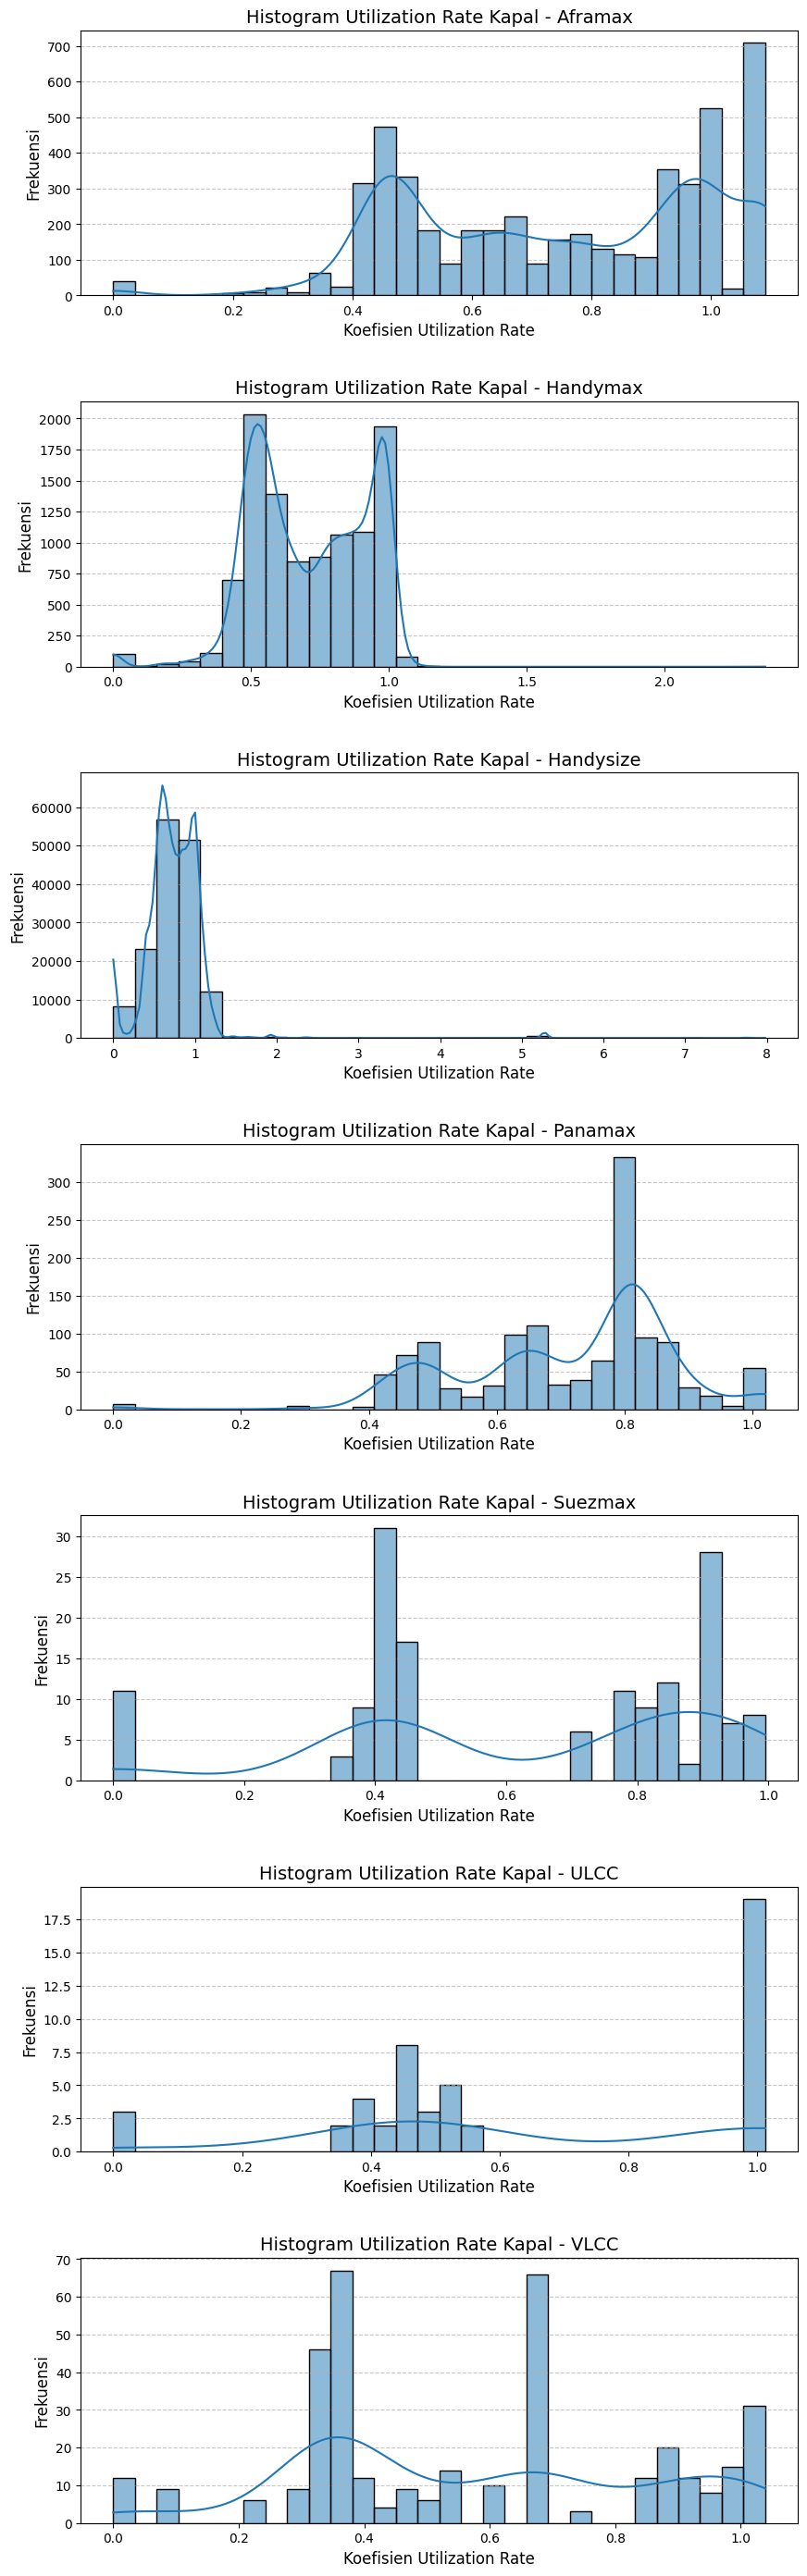

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Dapatkan daftar unik kelas_kapal
kelas_list = imputed_cbd_pd["kelas_kapal"].unique()

# Tentukan jumlah subplot berdasarkan jumlah kelas_kapal
n_kelas = len(kelas_list)
fig, axes = plt.subplots(n_kelas, 1, figsize=(10, 5 * n_kelas), sharex=False, sharey=False)  # Tidak share sumbu

# Jika hanya ada satu kelas_kapal, pastikan axes tetap array agar bisa di-loop
if n_kelas == 1:
    axes = [axes]

# Loop untuk setiap kelas_kapal dan buat histogramnya
for i, kelas in enumerate(kelas_list):
    ax = axes[i]
    data_kelas = imputed_cbd_pd[imputed_cbd_pd["kelas_kapal"] == kelas]

    # Plot histogram tanpa share axis
    sns.histplot(data_kelas, x="payload", bins=30, kde=True, edgecolor='black', ax=ax)

    # Atur judul dan label sumbu
    ax.set_title(f"Histogram Utilization Rate Kapal - {kelas}", fontsize=14)
    ax.set_xlabel("Koefisien Utilization Rate", fontsize=12)
    ax.set_ylabel("Frekuensi", fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Tambahkan ruang antar subplot agar label tidak bertumpuk
plt.subplots_adjust(hspace=0.4)

# Tampilkan plot
plt.show()

## Simpan Data

In [71]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "212112409/"

In [72]:
#save as parquet
data_ais_payload.write.option("header",True).mode("overwrite").parquet(save_path_unique + "ais-data-payload-2020.parquet")

## Hitung Displacement

In [ ]:
from pyspark.sql.functions import col

# Konstanta ρ (rho)
rho = 1.025

# Tambahkan kolom "disp"
data_ais_displacement = data_ais_payload.withColumn(
    "displacement",
    rho * col("LBP") * col("BreadthMoulded") * col("dreported") * col("cbdesign")
)

# Tampilkan hasil untuk verifikasi
data_ais_displacement.select(
    "mmsi", "cbdesign", "dreported", "LBP", "BreadthMoulded", "displacement"
).show(n=1000, truncate=False)

## Simpan Data

In [ ]:
#save as parquet
data_ais_displacement.write.option("header",True).mode("overwrite").parquet(save_path_unique + "ais-data-displacement-2020.parquet")

In [73]:
spark.stop()